In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/AI_Power_Trader_Data/'

Mounted at /content/drive


###Table of content
1.  Business Understanding
2.  Data Understanding
3.  Data Processing
  - Missing Value Exploration 
  - Group data 
  - Delete null value
4.  EDA : 
    *   Univariate Analysis (by group)
    *   Timeseries Analysis
    *   ImbalanceQuantity Exploration 


### Business Understanding 
Analysing and predicting demand and supply of energy market are the keys to make trading decisions.

This project focuses on breaking down and analysing features of Elexon Portal Data ( [github](https://github.com/OSUKED/ElexonDataPortal)) to predict NIV (Net Imbalance Volume).

This notebook contains steps to process data and insights to find out relationship between NIV (MAW-ImbalanceQuantity) and other features.

### Data Understanding
Some definition related to data:

Generation
* (B1430)-Day-Ahead Aggregated Generation
* (B1440)-Generation Forecasts for Wind Solar
* (B1620)-Actual Aggregated Energy
* (B1630)-Actual or Estimated Wind and Solar Power 

Energy Load: 
* (B0620)-Day-Ahead Total Load Forecast per Bidding Zone
* (B0610)-Actual Total Load per Bidding Zone

Demand 
* ITSDO: Initial Transmission System Demand Out-Turn 
* TSDF: Transmission System Demand Forecast

Interconnector
* INTNSL: External Interconnector flows with Norway 2 (North Sea Link) <br>
* INTIFA2 – External Interconnector flows with France (IFA2)<br>
* INTELEC – External Interconnector flows with France (ElecLink)<br>
* INTNEM  - External Interconnector flows with Belgium (NemoLink)<br>
* INTEW   - External Interconnector flows with Ireland (East-West)<br>
* INTNED - External Interconnector flows with the Netherlands<br>
* INTIRL - External Interconnector flows with Ireland<br>
* INTFR - External Interconnector flows with France<br>

Day Ahead data (begin with DA- ) 
* DAID - Indicated Demand
* DAIG - Indicated Generation
* DANF - National Demand Forecast
* DATF - Transmission System Demand Forecast

## Data Processing

In [ ]:
# import library
# !pip install statsmodels --upgrade
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import math
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Read Data
df = pd.read_csv(data_path + 'merged.csv')
# df.info()

In [ ]:
# df.head()

In [ ]:
# Data Description
missing_count = df.isnull().sum()
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'total_row' : df.shape[0],
                                 'unique_value': df.apply(lambda col: col.nunique()),
                                 'missing_count': missing_count,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)
# missing_value_df[missing_value_df['missing_count'] != 0]

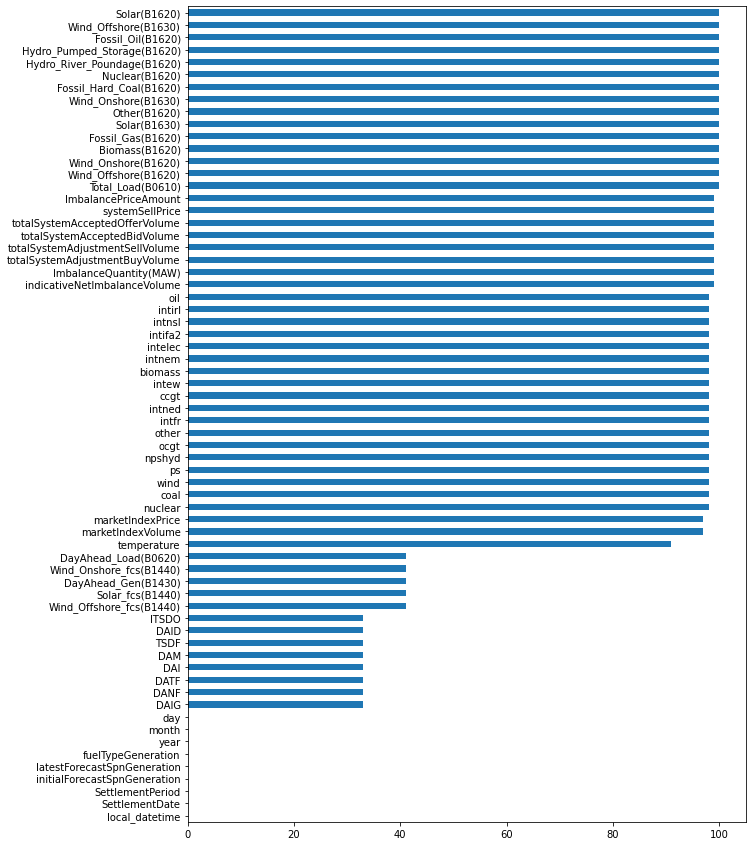

In [ ]:
# Plot count of missing value
plt.figure(figsize=(10,15))
df.isnull().sum().sort_values().plot(kind='barh')

Based on count of missing value, we suspect that some of the missing values are not at random. 

*   For columns with 0 missing values: they're date columns, settlement. Notice that "fuelTypeGeneration", "initialForcastSpnGeneration" and "lastestForcastSpnGeneration" are in this group.
*   For columns with 33 missing values: it means 33 SettlementPeriod = 16.5 hrs. They're Day Ahead Data based on their name
*   For columns with 41 missing value: it means 41 SettlementPeriod = 20.5 hrs. They're Forcasting Energy based on their name (fcs)
*   For columns with 98 missing value: it means 98 SettlementPeriod = 49 hrs. They're different Energy Sources based on their name
*   For columns with 99 missing value: it means 99 SettlementPeriod = 49.5 hrs. They're Market Data based on their name
*   For columns with 100 missing value: it means 100 SettlementPeriod = 50 hrs. They're Actual/Aggregated Energy Sources based on their name.
*   Other columns like "temperature" with 91 missing, "MarketIndexVolume" and "MarketIndexValue" with 97 missing also show the delayed time and the kind of data we aggregated.

Later on, we will explore that in more detail. <br>
We plan to name groups like: 
* day_ahead_33 
* forecast_energy_41
* energy_source_98 
* market_data_99 
* actual_energy_src_100 


In [ ]:
# Check missing value's date if it's within one day of today 
# (exported data date : May 24 2022 21:00:00 - assumption) 

#Expected missing Date
missing_data_date = ['2022-05-23', '2022-05-24', '2022-05-25'] 
missing_cols = missing_value_df[missing_value_df['missing_count'] != 0].index

for col in missing_cols: 
  # Get list of missing data's date
  l = df[df[col].isnull()].SettlementDate.unique()
  for day in l:
    if day not in missing_data_date:
      raise("Missing value is not in intended range")

=> "Data is N/A" caused by the moment that we exported the CSV file. (May 24 2022 21:00:00 - our assumption) 

Data contains Forecast and Day Ahead so it would contain the next day in SettlementDate, and obiviously, some actual/reported/agregated is missing in SettlementDate of next day.

In [ ]:
# Assumption : Temperature column is 1 for all 48 values within a day, let's check it.
df.dropna().groupby('SettlementDate').temperature.apply(list).apply(lambda x: set(x)).apply(len).nunique()

1

=> Temperature : Average Temperature of a day (apply for 48 periods) 

We had some groups that show values for : 
1. Market Info (marketIndexVolume, marketIndexPrice, )
2. Weather (temp)
3. Forecasting 
4. Different energy type (solar, wind, ....)


### Univariate Analysis (by group) 




In [ ]:
ADDITIONAL_COLS = ['SettlementDate', 'SettlementPeriod', 'ImbalanceQuantity(MAW)']
def divide_data(missing_count,df=df, miss_df=missing_value_df):
  """
  This function divide hugeof missing value from the dataset.
    df=df : The huge dataset from the beginning
    miss_df=missing_value_df : missing dataframe aggregated above
  Returns:
    Dataframe
  """
  sub_df_columns = missing_value_df[missing_value_df['missing_count'] == missing_count].index.tolist() \
  + ADDITIONAL_COLS
  # Remove Duplicate columns if any
  sub_df_columns = list(dict.fromkeys(sub_df_columns))
  sub_df = df[sub_df_columns]
  # Drop all missing Data
  sub_df.dropna()
  return sub_df.reset_index(drop=True)

day_ahead_33           = divide_data(33)
forecast_energy_41     = divide_data(41)
energy_source_98       = divide_data(98)
market_data_99         = divide_data(99)
actual_energy_src_100  = divide_data(100)
datafrm_group = ['day_ahead_33', 'forecast_energy_41', 'energy_source_98', 'market_data_99', 'actual_energy_src_100']

In [ ]:
def univariate_plot(data_frm):
  """
  This function is used for plotting univariate analysis. 
  Removing SettlementDate, Period, MAW column which was added on the "divide_data" function
  Param:
    data_frm: dataframe for plotting -> pd.DataFrame
  Returns:
    Histograms in 3 columns format
  """
  fig, axs = plt.subplots(math.ceil(len(data_frm.columns)/3) -1, 3, figsize=(16,18))
  i=0
  cols = data_frm.columns.to_list()
  cols = [col for col in cols if col not in ADDITIONAL_COLS]
  for x in cols:
    axs[i // 3, i % 3].hist(data_frm[x], bins=20, alpha=0.6)
    axs[i // 3, i % 3].set_title(x)
    i=i+1 

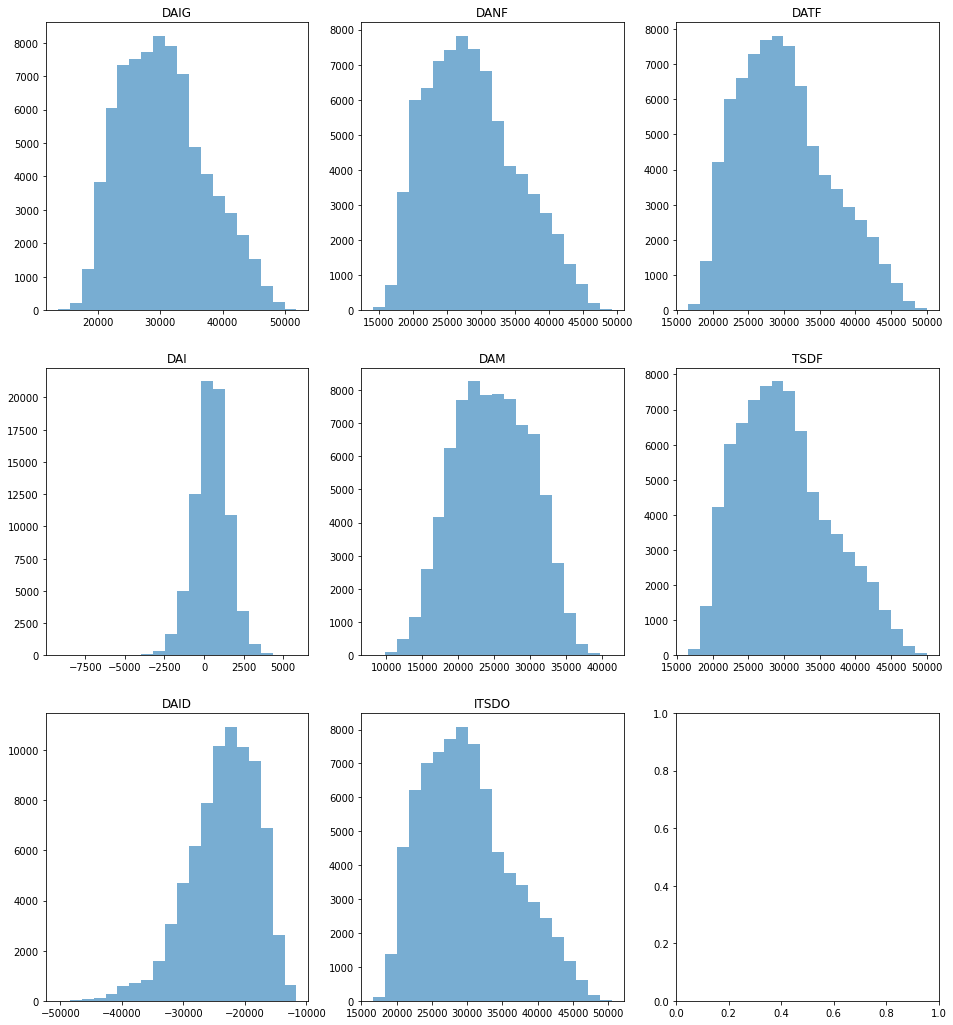

In [ ]:
univariate_plot(day_ahead_33)

Comment:

DAIG, DANF, DATF, TSDF and ITSDO shared the same distribution shape. <br>
DAID values are negative, if we use abs function for this column, its distribution is the same shape as the 5 figures above. <br>
DAI (Day Ahead Imbalance) fluctuate between 0 and arround 2500-3000. <br>
DAM (Day Ahead Margin) seems to be normally distributed.

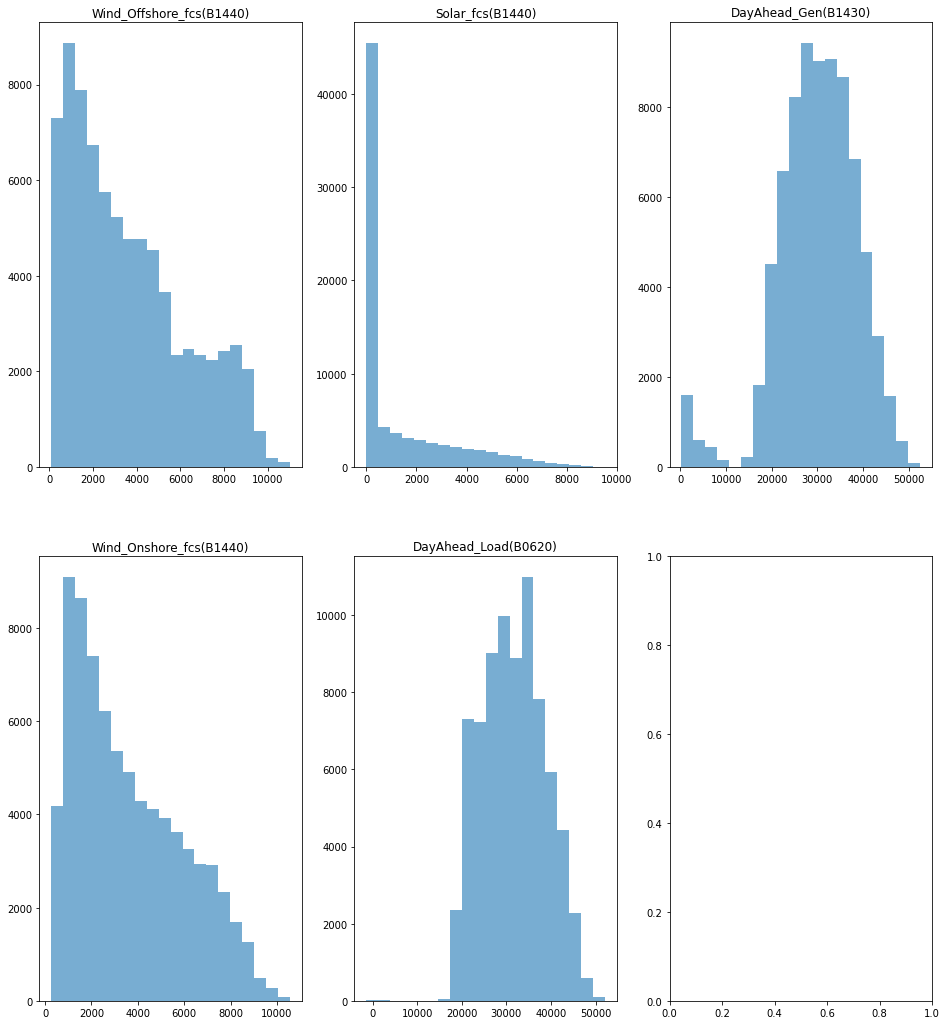

In [ ]:
univariate_plot(forecast_energy_41)

Comment:
Looking at the plots: 
- It can be that the values on the left tail of the DayAhead Generation(B1430) could be incorrect data. Energy generation is unlikely to be that low, and could consist of anomalies. 
- Another thing is that DayAhead Load(B0620) is distributed similarly to DayAhead Generation(B1430), which is to be expected. 
- Wind_Onshore_fcs(B1440) and Wind_Offshore_fcs(B1440) is also very similarly distributed, but offshore wind energy generation has higher overall count, which is directly related to total magnitude of energy generated.
- As for Solar_fcs(B1440), the data shows most commonly zero, but decreasingly distributed when it comes to the power generation count.

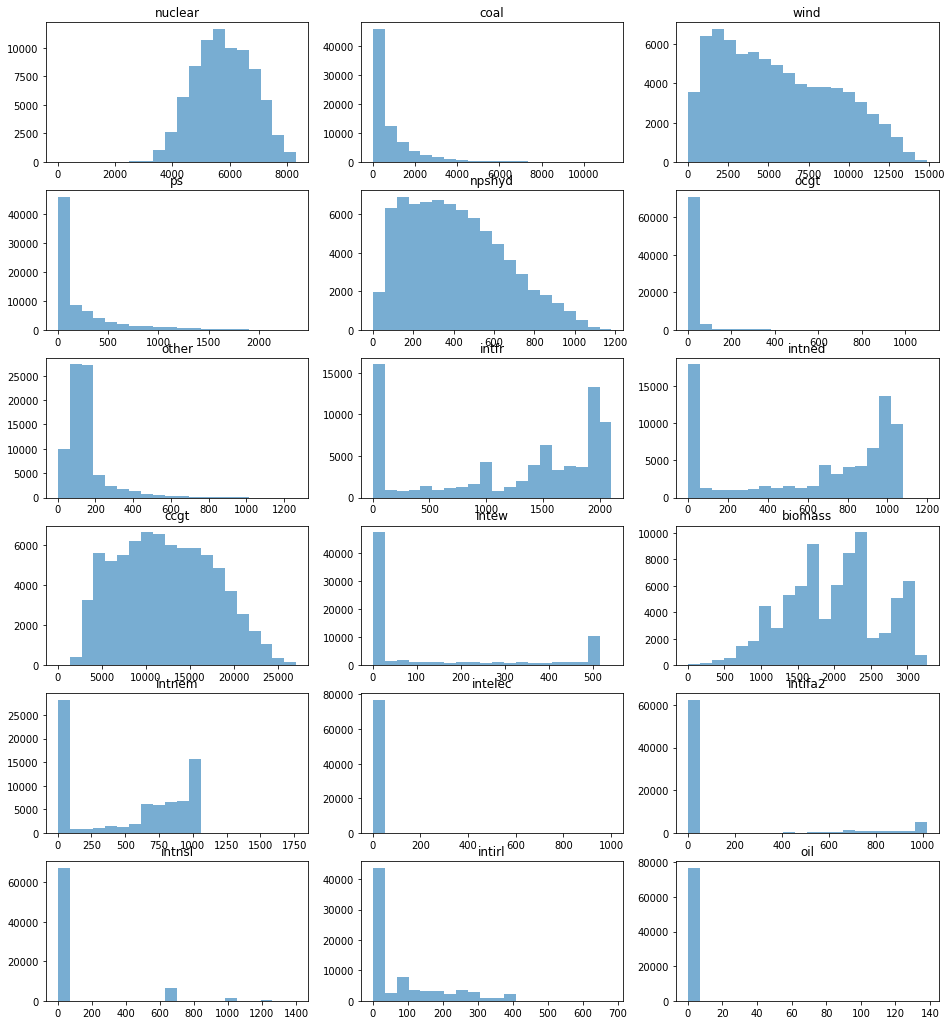

In [ ]:
univariate_plot(energy_source_98)

Looking at the figures: 
- Nuclear, Wind, npshyd (), ccgt and biomass are the common energy sources. CCGT accounts for the highest distribution, wind contributes the second position. 
- Coal, Oil, OCGT, PS are not very popular
- Interconnector sources shared different shape distribution in different countries.

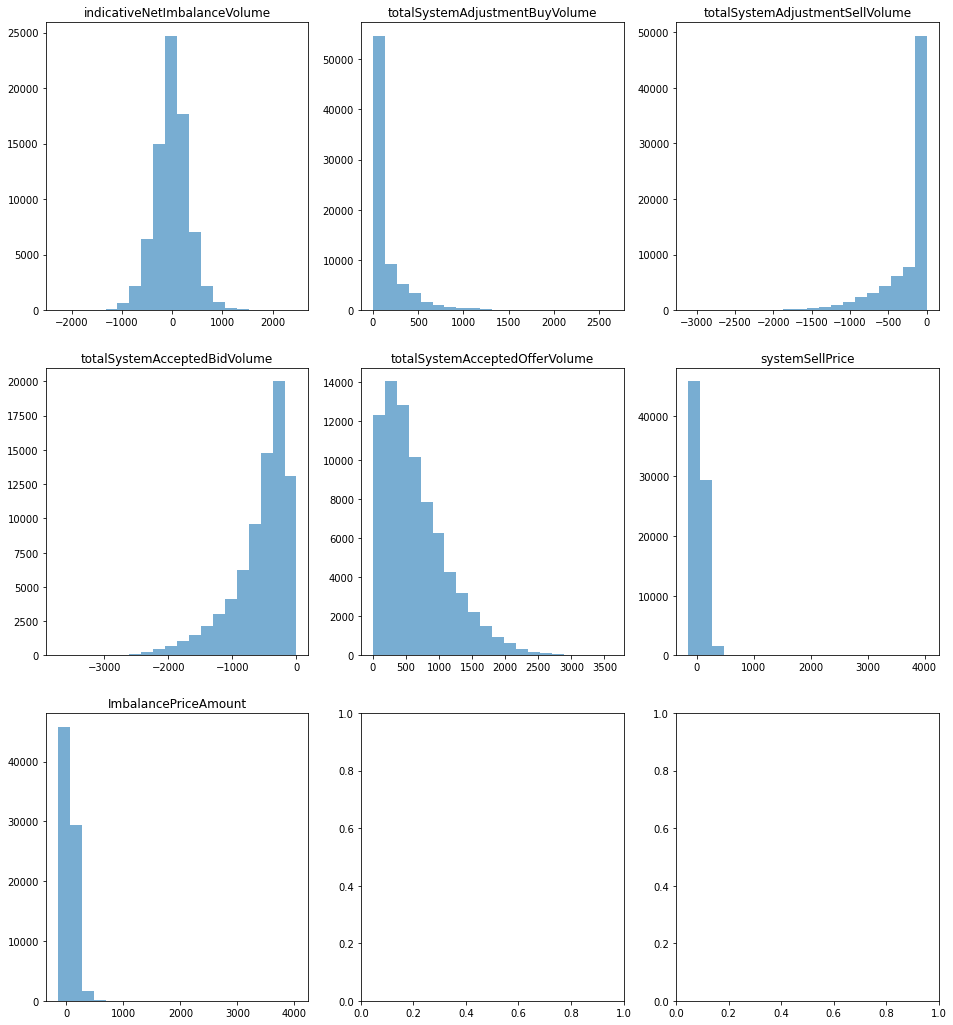

In [ ]:
univariate_plot(market_data_99)

Comment:
- totalSystemAdjustmentBuyVolume and totalSystemAdjustmentSellVolume transposed horizontally
- totalSystemAcceptedBidVolume and totalSystemAcceptedOfferVolume transposed horizontally, AcceptedOffer is a bit higher.
- SystemSellPrice and ImbalancePriceAmount look like the same.

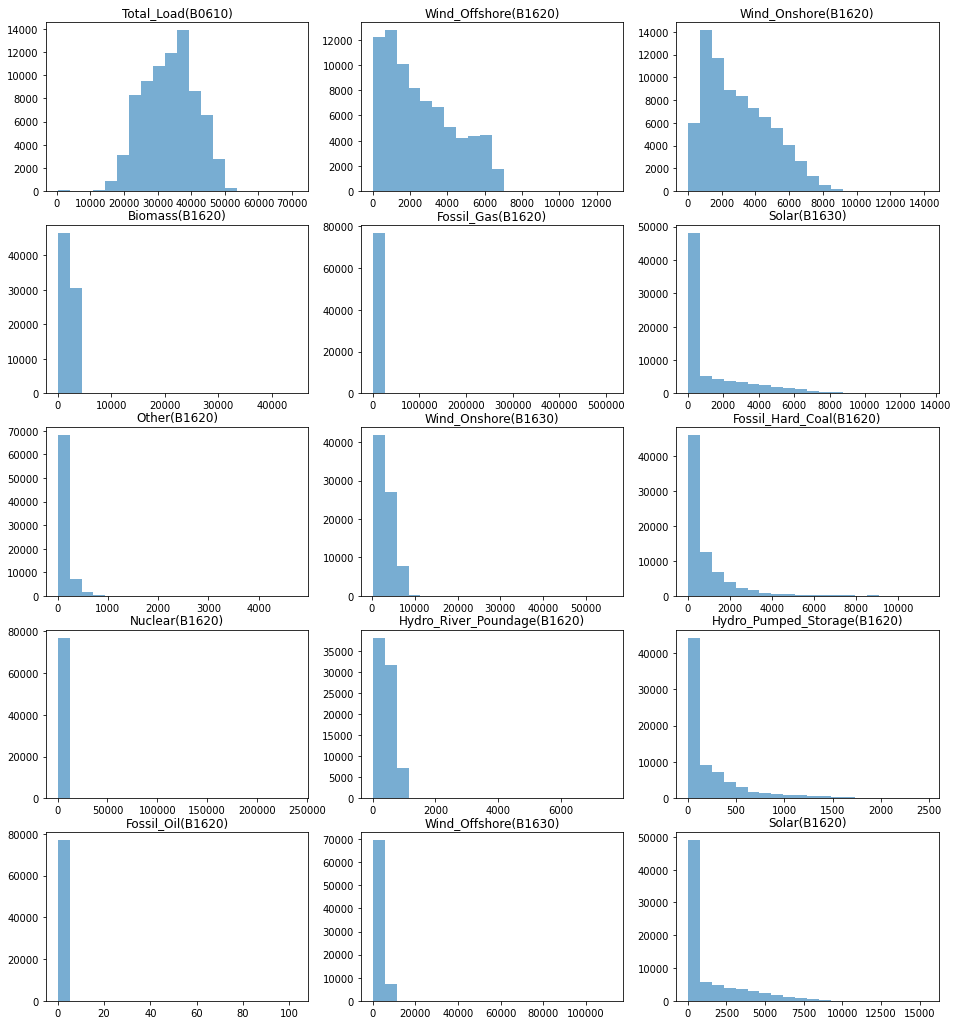

In [ ]:
univariate_plot(actual_energy_src_100)

Comment:

Like energy_source_98 group, They're possitive correlated each pair-wise, ex: Nuclear(B1620) and nuclear, ...


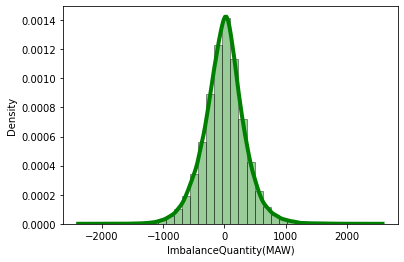

In [ ]:
sns.distplot(df['ImbalanceQuantity(MAW)'], hist=True, kde=True, \
             bins=36, color = 'green', \
             hist_kws={'edgecolor':'black'}, \
             kde_kws={'linewidth': 4})

Comment: 

MAW and Indicative NIV seem to be standardized and normally distributed, which is expected since we expect the mean to be zero, since the system should be somewhat balanced a lot of times. As for variance, We expect the tail to be small and that we want to be able to capture that later on in our models.

### Time series Analysis



With this section, we aim to breakdown the signals into distinct parts which are easier to understand. This will have two main sections:

1. Autocorrelation and Stationarity Exploration:
    Understand the data better, including what constitutes the signals that make up our target variable and as well as the features themselves. This shows us how the data relates to itself, which allows us to make inferences about the seasonality without explicitly using a model/decomposition.
2. Explicit Seasonal Decomposition:
    To see if there are any distinct subsignals that we can separate, and if these subsignals change over time. This will explore decompositions of the main signal into 3 components: trend, seasonality, and white noise. 

This will help us engineer better features and models in the later stages, which we want to incorporate as much prior knowledge as possible.

Firstly, group_by_day so that the data would be more solid

In [ ]:
DEFAULT_COLS = ['SettlementDate']
def extract_group_by_day(missing_count, df=df, missing_df=missing_value_df):
  """
  Helper function for extract data by group_by_day and perform some preprocessing.
  Param:
    missing_count: number of missing value
    df: dataframe for processing -> pd.DataFrame
    missing_df: table that aggregate missing values
  Returns:
    pd.Dataframe that is grouped by Date - mean method
  """
  columns = DEFAULT_COLS + missing_value_df[(missing_value_df['missing_count'] == missing_count)].index.tolist()
  sub_df = df[columns].dropna()
  sub_df['SettlementDate'] = pd.to_datetime(sub_df.SettlementDate)
  sub_df = sub_df.groupby('SettlementDate').mean().reset_index()
  return pd.melt(sub_df, ['SettlementDate']).sort_values('SettlementDate')

In [ ]:
# _gbd_ :Group by day 
datafrm_group_gbd = ['day_ahead_gbd_33', 'forecast_energy_gbd_41', 'energy_source_gbd_98', 
                     'market_data_gbd_99', 'actual_energy_src_gbd_100']
day_ahead_gbd_33           = extract_group_by_day(33)
forecast_energy_gbd_41     = extract_group_by_day(41)
energy_source_gbd_98       = extract_group_by_day(98)
market_data_gbd_99         = extract_group_by_day(99)
actual_energy_src_gbd_100  = extract_group_by_day(100)
day_ahead_gbd_33

SettlementDate variable         value
0         2018-01-01     DAIG  30029.229167
11242     2018-01-01    ITSDO  30221.625000
3212      2018-01-01     DATF  29452.458333
4818      2018-01-01      DAI    576.687500
9636      2018-01-01     DAID -22892.312500
...              ...      ...           ...
4817      2022-05-25     DATF  19876.000000
3211      2022-05-25     DANF  19137.500000
1605      2022-05-25     DAIG  21508.500000
11241     2022-05-25     DAID -19082.900000
12847     2022-05-25    ITSDO  28860.000000

[12848 rows x 3 columns]

In [ ]:
# da_df.groupby('variable').value.mean() / da_df.groupby('variable').value.std()

In [ ]:
day_ahead_gbd_33.groupby('variable').value.describe()

count          mean          std           min           25%  \
variable                                                                  
DAI       1606.0    456.472330   759.977258  -2330.000000    -29.651042   
DAID      1606.0 -23471.059882  4314.502484 -41741.500000 -26027.838542   
DAIG      1606.0  30528.720151  4792.992424  17700.604167  27338.968750   
DAM       1606.0  24760.043846  3310.994162  14319.041667  22402.546875   
DANF      1606.0  28749.950615  4397.742216  17783.916667  25535.208333   
DATF      1606.0  30071.332088  4492.077293  19437.583333  26847.213542   
ITSDO     1606.0  30079.904252  4419.201244  19539.416667  26861.484375   
TSDF      1606.0  30071.332088  4492.077293  19437.583333  26847.213542   

                   50%           75%           max  
variable                                            
DAI         502.375000    998.286458   2678.583333  
DAID     -22987.864583 -20435.531250 -14591.375000  
DAIG      30162.072917  33936.291667  43064.229167  
DAM       24543.145833  26804.817708  35524.333333  
DANF      28237.062500  32066.921875  40681.812500  
DATF      29519.333333  33394.067708  41923.729167  
ITSDO     29508.333333  33329.406250  42056.895833  
TSDF      29519.333333  33394.067708  41923.729167

DAID: Day Ahead Indicated Demand. Its values are negative because it reflect the Demand volume, which is opposite to the Supply (possitive value)

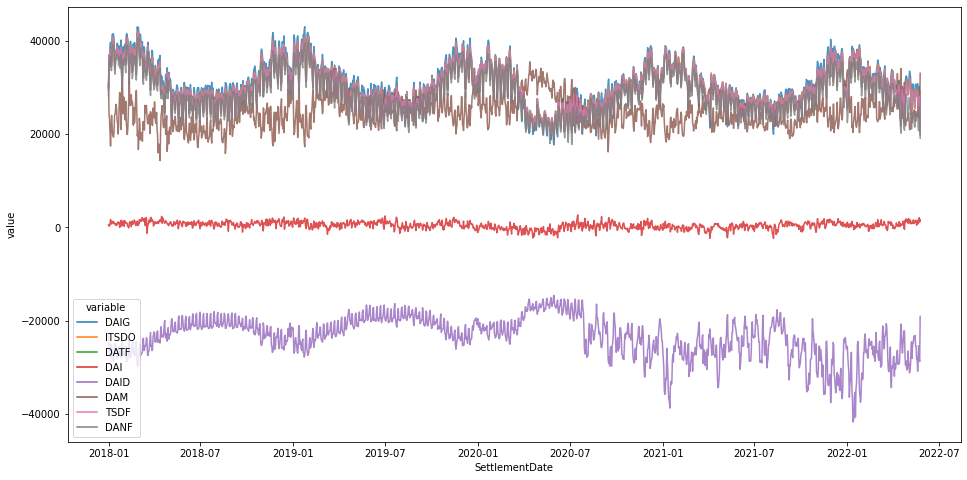

In [ ]:
plt.figure(figsize=(16,8))
sns.lineplot(x=day_ahead_gbd_33['SettlementDate'], y=day_ahead_gbd_33['value'], hue=day_ahead_gbd_33['variable'], alpha = 0.8)

There're some cosin shapes if we plot data grouped by day (except DAM, DAI). They showed seasonality of some specific data. 

Looking at the DAID (Indicated Demand). There was a huge change since 2020-08, The demand became significant high and fluntuated with high amplitude. But the pattern look like the same compared to previous year (highest in January and lowest in July)

In [ ]:
def line_plot(variable, data_frm, figsize=(16,8), window=None):
  col,row = 2, len(variable) // 2 + 1
  plt.figure(figsize=(20,15))
  for i in range(len(variable)):
      plt.subplot(row,col,i+1)
      d = data_frm[data_frm.variable == variable[i]].reset_index(drop=True)
      if window:
        d['value'] = d.value.rolling(window).mean()
      sns.lineplot(x=d['SettlementDate'], y=d['value'], hue=d['variable']).set_title(f"Trend line of {variable[i]}")
  plt.tight_layout()
  plt.show()

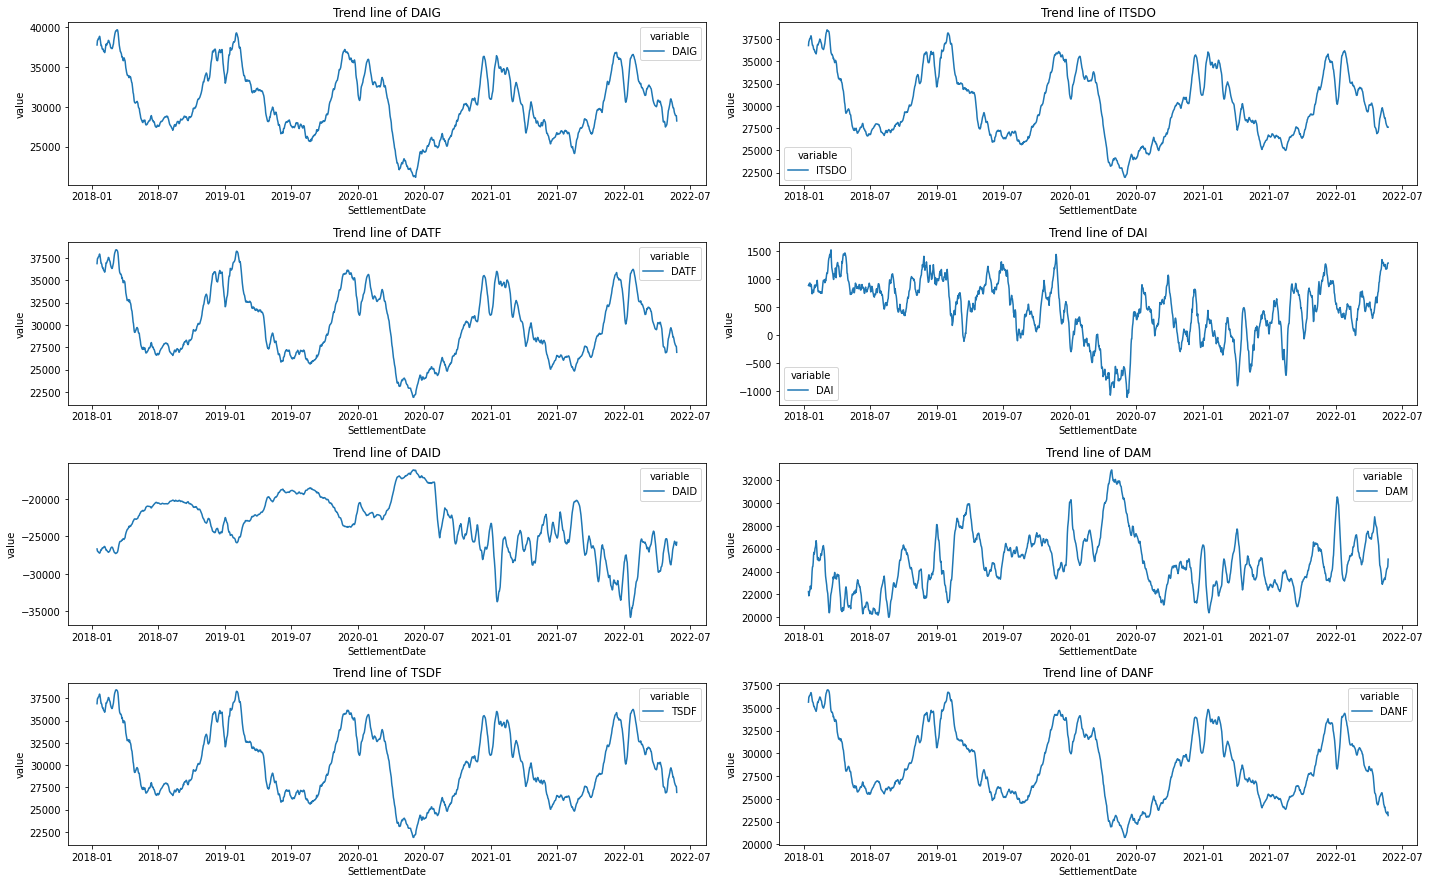

In [ ]:
line_plot(day_ahead_gbd_33.variable.unique(), day_ahead_gbd_33, window=14)

By trend line we can split data to 2 groups:


1.   DAIG, DATF, TSDF, DANF, ITSDO has the same pattern.
2.   DAID, DAI, DAM doesn't look alike with the group 1.



In [ ]:
def seasonal_decompose_plot(category, df=day_ahead_gbd_33):
  decomp = seasonal_decompose(df[df.variable == category].set_index("SettlementDate").value)
  fig, ax = plt.subplots(3, 1, figsize = (15, 8))
  decomp.resid.plot(kind = 'line', ax = ax[0]); ax[0].set_title('Residual')
  decomp.seasonal.plot(kind = 'line', ax = ax[1]); ax[1].set_title('Seasonality')
  decomp.trend.plot(kind = 'line', ax = ax[2]); ax[2].set_title('trend')
  plt.tight_layout()

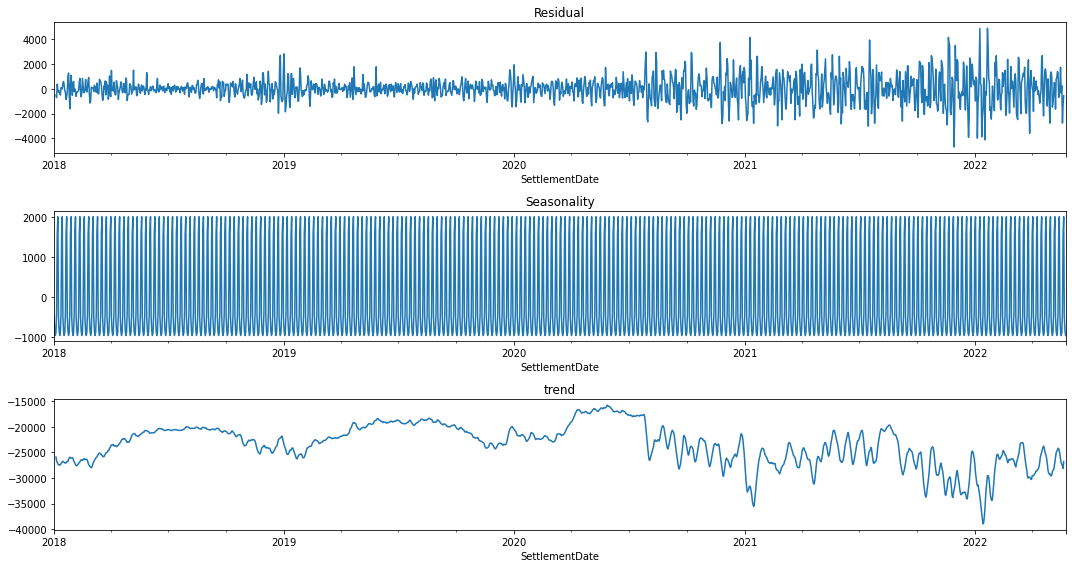

In [ ]:
seasonal_decompose_plot("DAID")

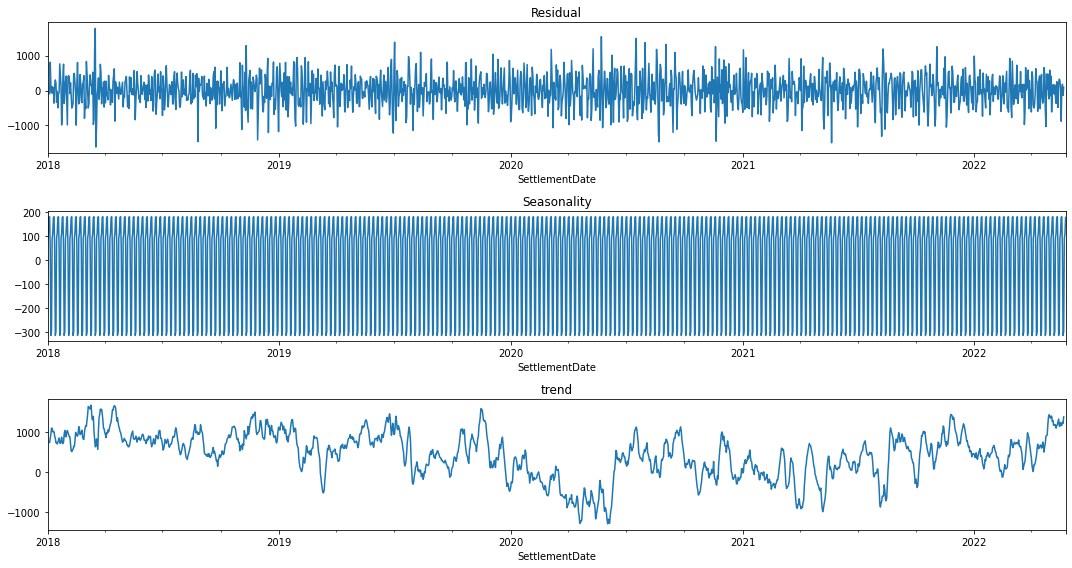

In [ ]:
seasonal_decompose_plot("DAI")

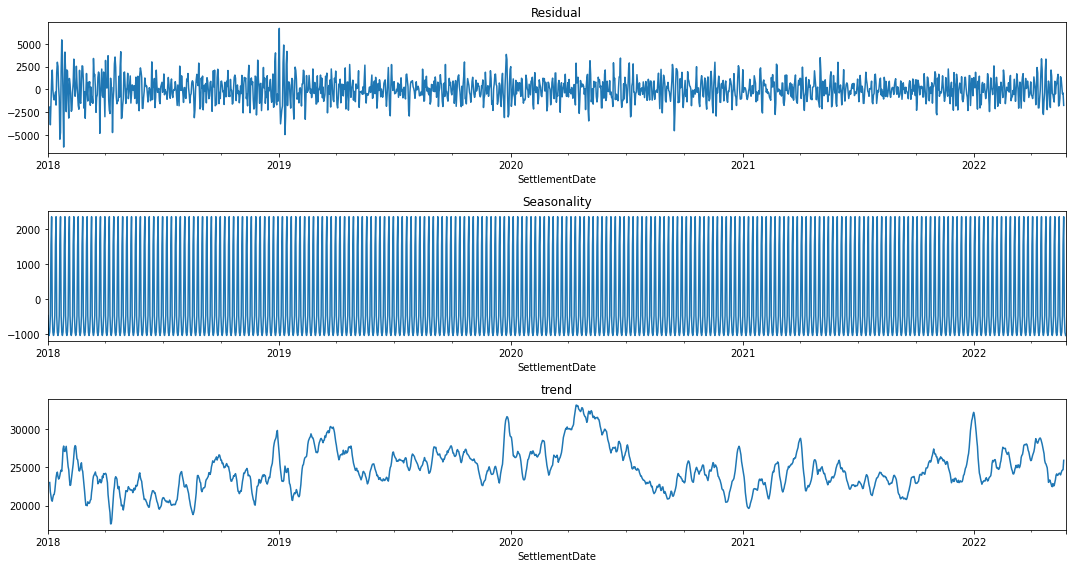

In [ ]:
seasonal_decompose_plot("DAM")

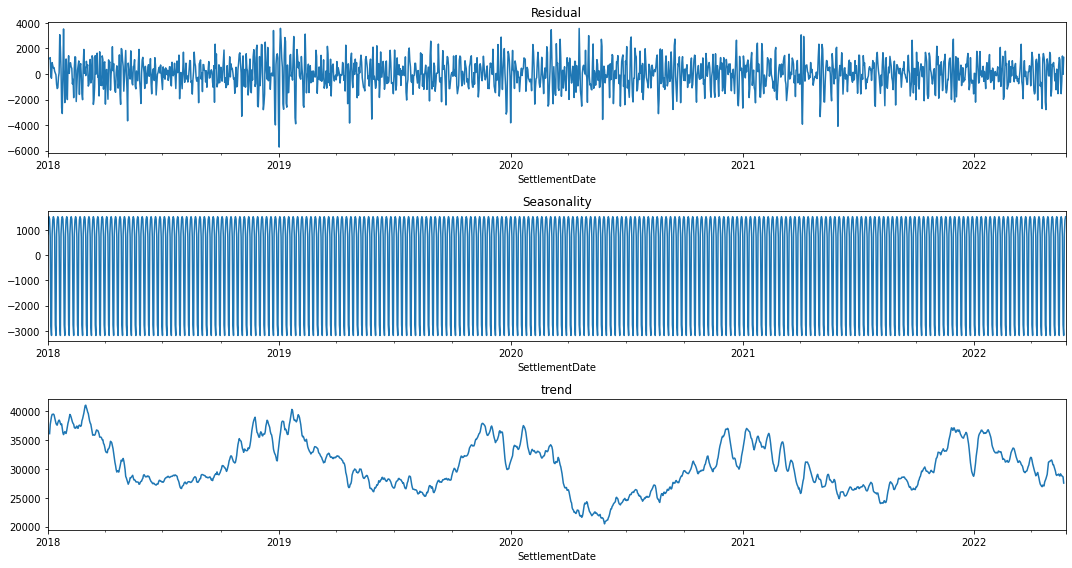

In [ ]:
seasonal_decompose_plot("DAIG")

With the above charts:

1. With Residual chart, DAID show the pattern that Covid had effected to the Demand in Enegergy. Residual fluntuate with high Amplitude since 2020-08.
2. For Other columns, Residual throughout watching time doesn't show a significant pattern

Let's investigate more:

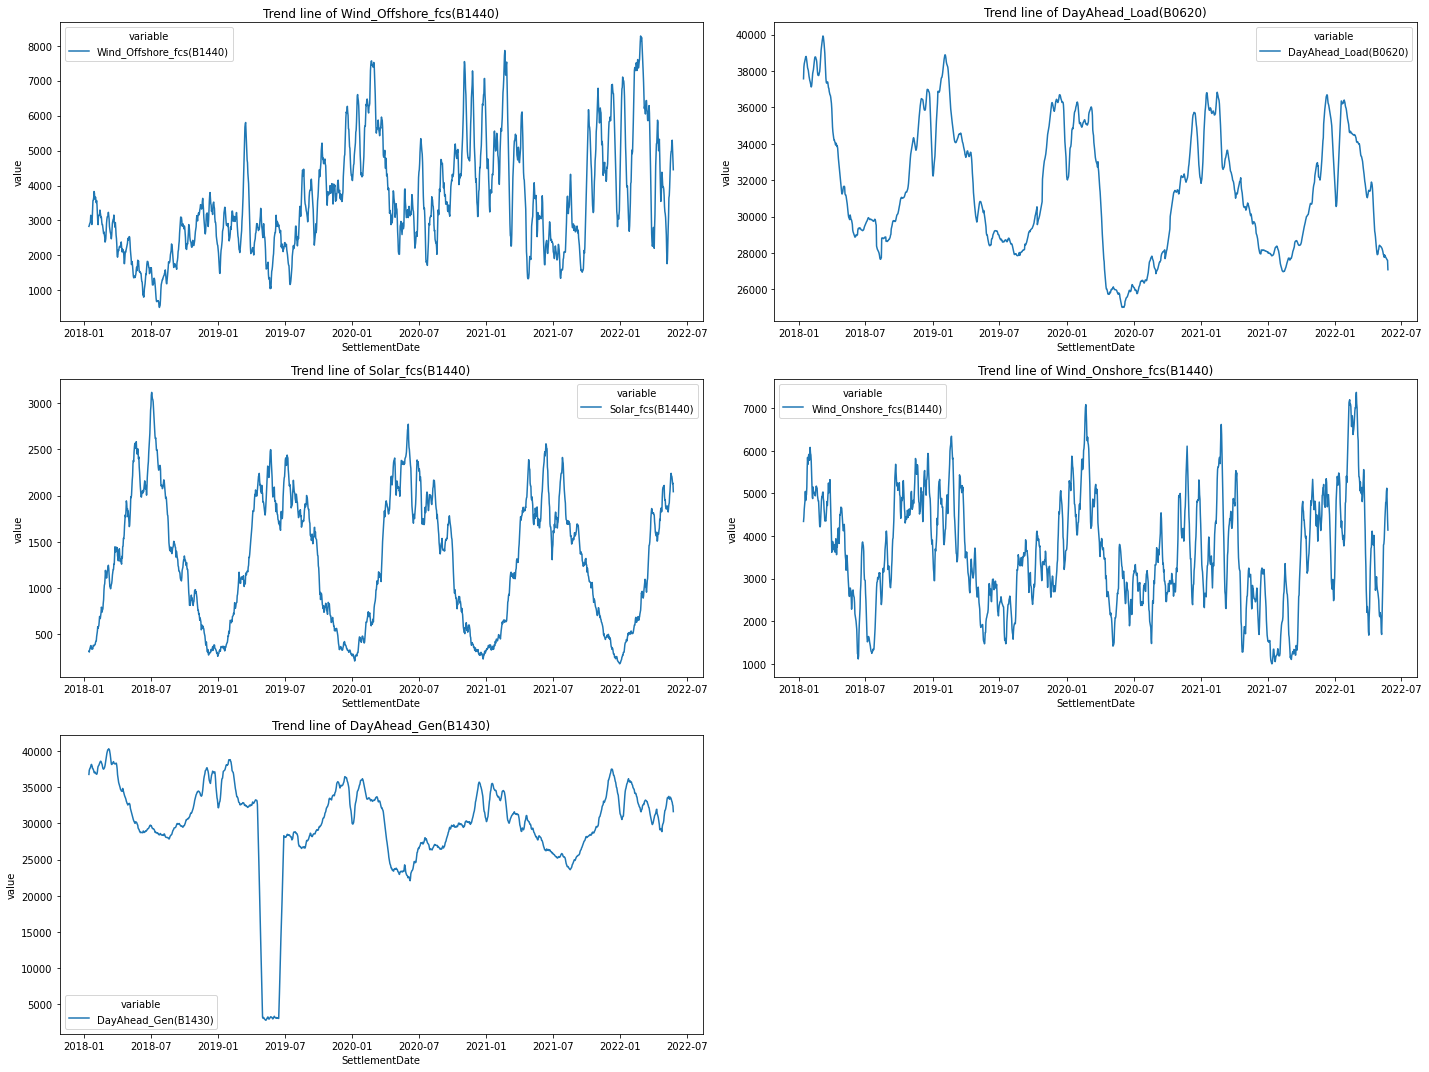

In [ ]:
line_plot(forecast_energy_gbd_41.variable.unique(), forecast_energy_gbd_41, window=14)

There's a obiviously a seasonal trend in all kind of Forecast Data above, but the distribution may be different. There was a significant plummet on 2019-06 from Generation amount.

Looking at Day-Ahead_gen, we witnessed a possible anomaly. We can use some model using some techniques as adversarial validation to check if this come from the same distribution as the data. (Modeling phase if necessery)

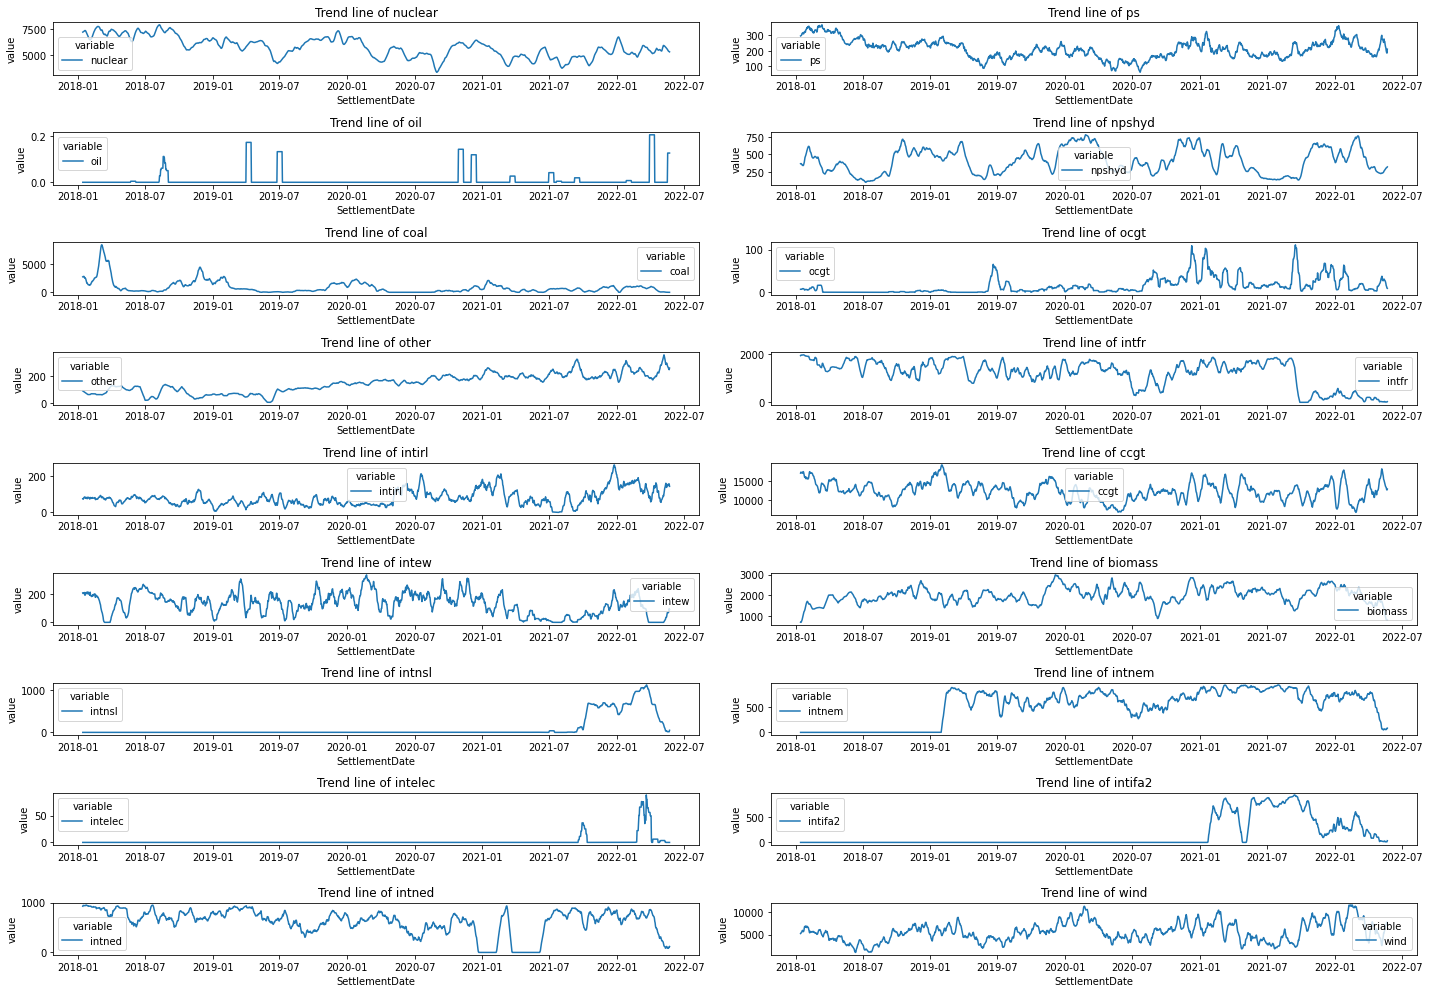

In [ ]:
line_plot(energy_source_gbd_98.variable.unique(), energy_source_gbd_98, window=14)

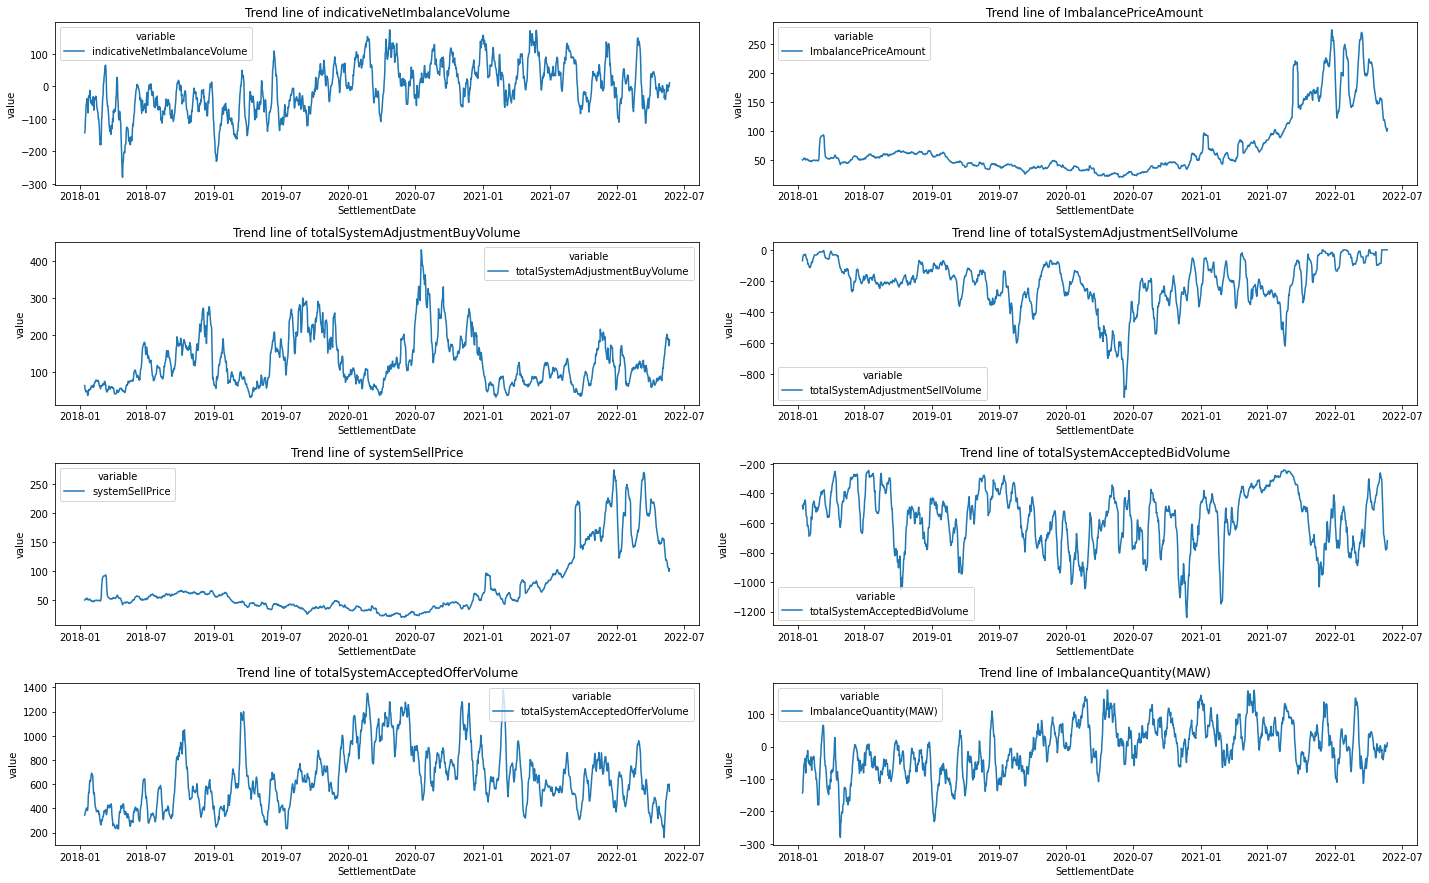

In [ ]:
line_plot(market_data_gbd_99.variable.unique(), market_data_gbd_99, window=14)

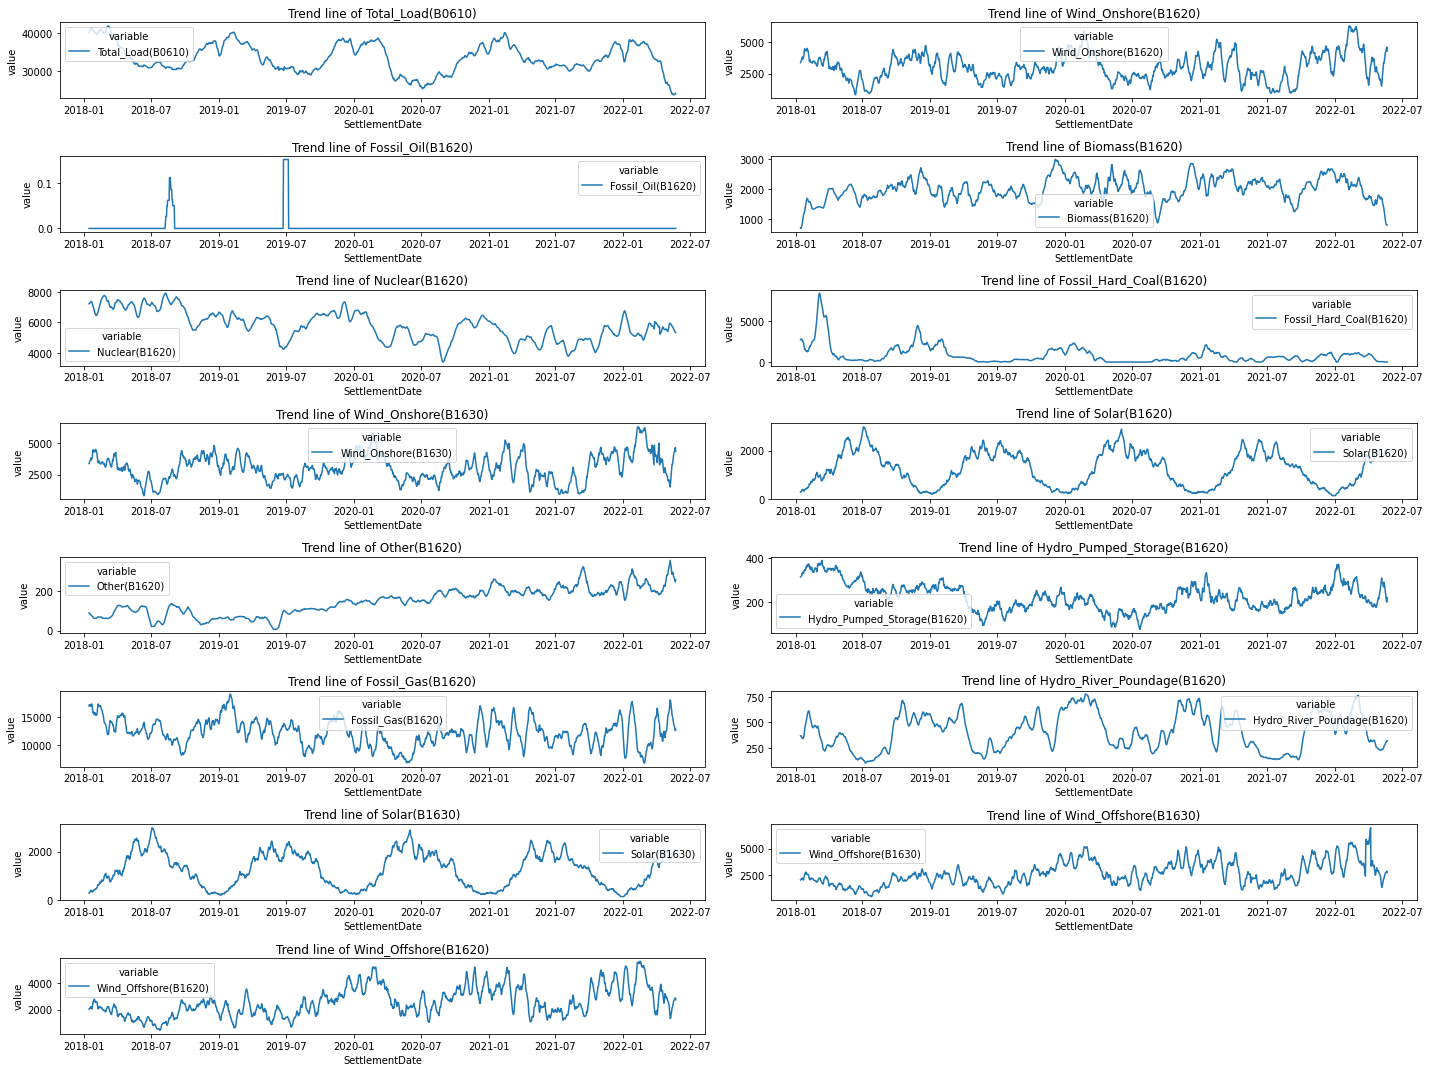

In [ ]:
line_plot(actual_energy_src_gbd_100.variable.unique(), actual_energy_src_gbd_100, window=14)

#### Autocorrelation and Stationarity Exploration

In [ ]:
# import modules for this section
import datetime
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

For the target variable, I hypothesize that there will be strong autocorrelation between small lag values, but also that these lags persist throughout the entire data, even with anomalies included. 
- This is because energy demand/supply is expected to be highly seasonal, which means that the imbalance autocorrelation is likely to persist through long periods of time. 

In [ ]:
def plot_acf_(array, plot_params=None):
    # plot the acf for a given array
    # make fixed size acf plot of target_var for weekly data
    fig, ax = plt.subplots(figsize=(10, 7))
    plot_acf(array, ax=ax, **plot_params)
    ax.set_ylabel("Degree of Autocorrelation")
    ax.set_xlabel("Lag")
    ax.set_ylim(-0.6)

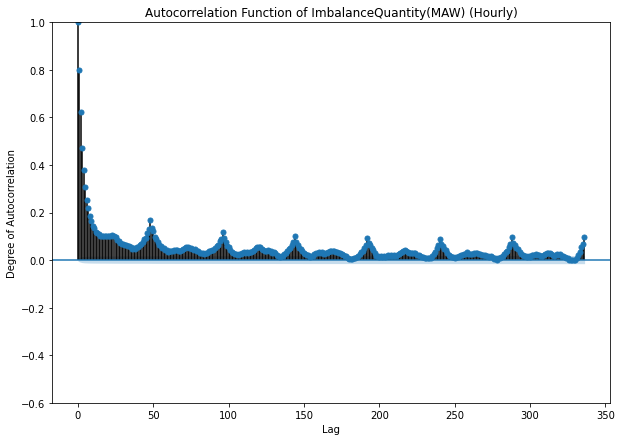

In [ ]:
# get imbalance quantity as array and plot acf for 7 days in hourly granularity
plot_acf_(df["ImbalanceQuantity(MAW)"].copy(), 
           {"missing":"drop", 
           "lags":48*7, 
           "title":"Autocorrelation Function of ImbalanceQuantity(MAW) (Hourly)"})
plt.show()

We can see that there is non-negligible autocorrelation during a day's data, but also that there is a strong autocorrelation between the same time each day, and that this correlation persists. We will now show that this applies fully to the entire duration of the data. 

First, we will show how this looks when aggregated over the entire dataset. Note that this might not be entirely representative of the dataset, since different years' data might come from vastly different distributions.

In [ ]:
# make some features out of SettlementDate
# compute settlement week for averaging
df["SettlementDate"] = pd.to_datetime(df["SettlementDate"])
df["SettlementWeek"] = df["SettlementDate"].apply(lambda x: datetime.date(x.year, x.month, x.day).isocalendar()[1])

# compute weekly aggregated data over the entire period
agg_target_weekly_avg = df.groupby(["SettlementWeek"])["ImbalanceQuantity(MAW)"].agg("mean")

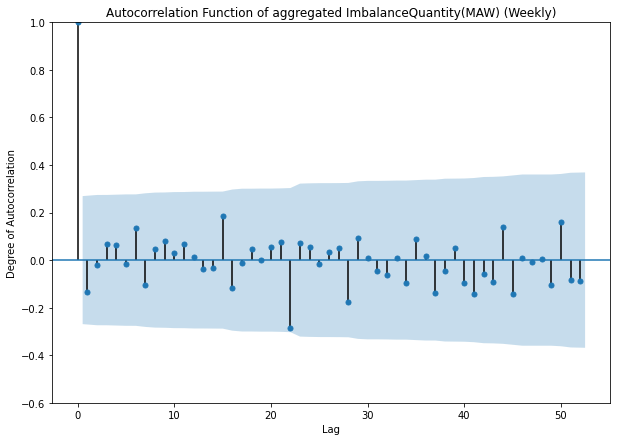

In [ ]:
# make acf plot of target_var for aggregated weekly data
plot_acf_(agg_target_weekly_avg, 
          {"lags":len(agg_target_weekly_avg)-1,
           "title":"Autocorrelation Function of aggregated ImbalanceQuantity(MAW) (Weekly)"})
plt.show()

We can see that when aggregated, the autocorrelation shows us a noticeable seasonal pattern in the data. This prompts further examination of the autocorrelation. We will now split the data into the 4 most recent years, and plot the autocorrelation separately.

The hypothesis for this is that the data pre-Covid is from a different distribution, so we want to design our models and features around that. Target is computed in a grouped way, that counts the +1 or +2 days in a 52 week year.

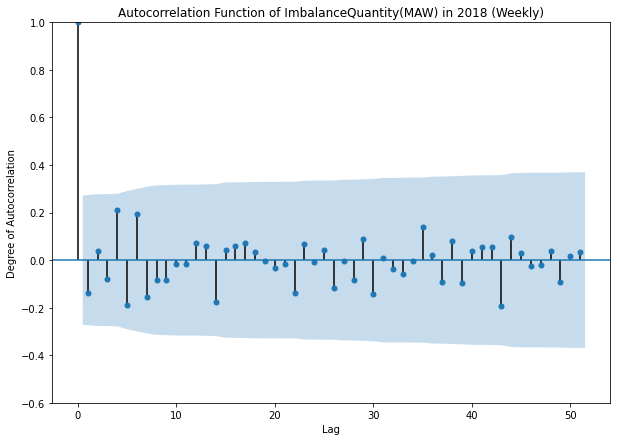

In [ ]:
# make acf plot of target_var for 2018's weekly data
target_weekly_avg_2018 = df[df["year"] == 2018].groupby(["SettlementWeek"])["ImbalanceQuantity(MAW)"].agg("mean")
plot_acf_(target_weekly_avg_2018, 
          {"lags":len(target_weekly_avg_2018)-1,
           "title":"Autocorrelation Function of ImbalanceQuantity(MAW) in 2018 (Weekly)"})
plt.show()

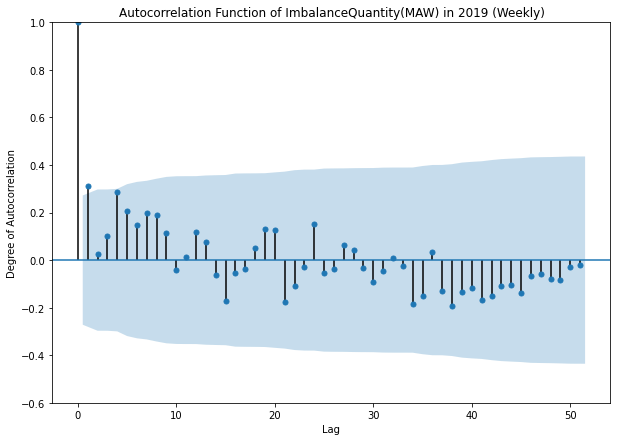

In [ ]:
# make acf plot of target_var for 2019's weekly data
target_weekly_avg_2019 = df[df["year"] == 2019].groupby(["SettlementWeek"])["ImbalanceQuantity(MAW)"].agg("mean")
plot_acf_(target_weekly_avg_2019, 
          {"lags":len(target_weekly_avg_2019)-1,
           "title":"Autocorrelation Function of ImbalanceQuantity(MAW) in 2019 (Weekly)"})
plt.show()

For post-2020 data, we expect the imbalance quantity to have more irregularities in short bursts.

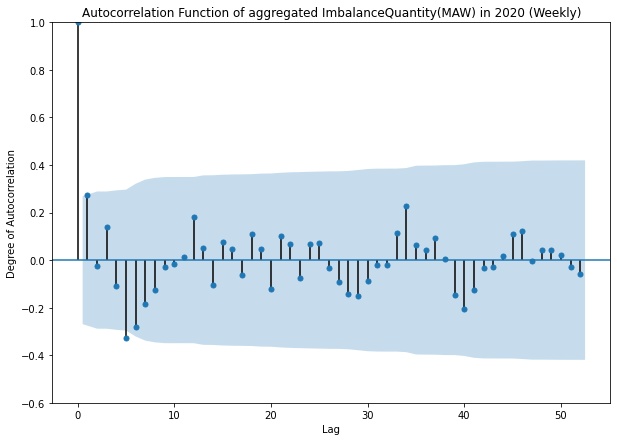

In [ ]:
# make acf plot of target_var for 2020's weekly data
target_weekly_avg_2020 = df[df["year"] == 2020].groupby(["SettlementWeek"])["ImbalanceQuantity(MAW)"].agg("mean")
plot_acf_(target_weekly_avg_2020, 
          {"lags":len(target_weekly_avg_2020)-1,
           "title":"Autocorrelation Function of aggregated ImbalanceQuantity(MAW) in 2020 (Weekly)"})
plt.show()

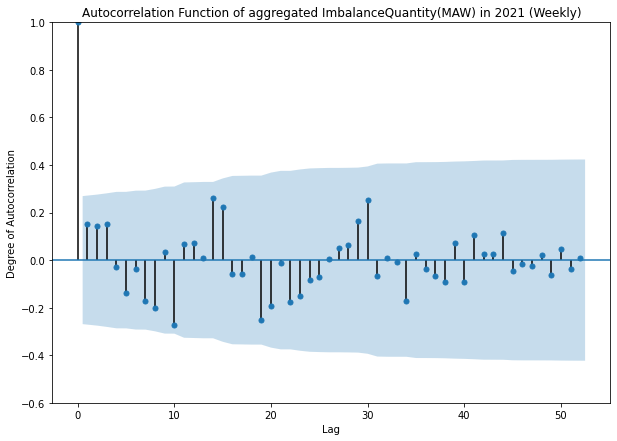

In [ ]:
# make acf plot of target_var for 2021's weekly data
target_weekly_avg_2021 = df[df["year"] == 2021].groupby(["SettlementWeek"])["ImbalanceQuantity(MAW)"].agg("mean")
plot_acf_(target_weekly_avg_2021, 
          {"lags":len(target_weekly_avg_2021)-1,
           "title":"Autocorrelation Function of aggregated ImbalanceQuantity(MAW) in 2021 (Weekly)"})
plt.show()

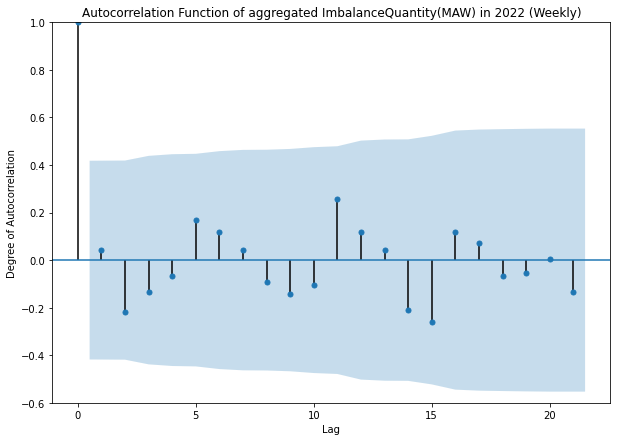

In [ ]:
# finally, the data for 2022 given current circumstances
target_weekly_avg_2022 = df[df["year"] == 2022].groupby(["SettlementWeek"])["ImbalanceQuantity(MAW)"].agg("mean")
plot_acf_(target_weekly_avg_2022, 
          {"lags":len(target_weekly_avg_2022)-1,
           "title":"Autocorrelation Function of aggregated ImbalanceQuantity(MAW) in 2022 (Weekly)"})
plt.show()

We can conclude that while the autocorrelation is not significant in the mathematical sense, we still gained valuable information from the previous plots. Autocorrelation is the strongest in 2020, when Covid started, which caused a lot of changes in work/living habits. 

We can see that for 2022, the confidence covers a higher absolute degree of autocorrelation and that the level of autocorrelation from around the 10th and 11th week onwards could be much more extreme due to current circumstances, especially compared to previous years (pre-2018, and even 2021 as well), when the correlation was likely due to the weather and Covid changes.

Examining the autocorrelation function of all the other features in our case would take too much work as well as potentially misleading us from the key insights, so we won't be examining the full feature set. Instead, we will explore the features that have the highest Pearson correlation with the imbalance quantity shown in the last section later on.

#### Explicit Seasonal Decomposition 

We saw how the target exhibits a weakly seasonal pattern, but what about the demand and supply? Do they have the same seasonal patterns? In the following section we will show that they are weakly correlated, so their autocorrelation is likely different. 

That being said, we will explore a few features on both sides to illustrate their characteristics. We will be using da_df from before, as well as some new calculations on the original dataframe. Just to quickly show how we grouped the data:

In [ ]:
# make some features out of SettlementDate
# compute settlement week for averaging
day_ahead_gbd_33["SettlementWeek"] = day_ahead_gbd_33["SettlementDate"].apply(lambda x: datetime.date(x.year, x.month, x.day).isocalendar()[1])
day_ahead_gbd_33["SettlementYear"] = day_ahead_gbd_33["SettlementDate"].apply(lambda x: x.year)
day_ahead_gbd_33["SettlementMonth"] = day_ahead_gbd_33["SettlementDate"].apply(lambda x: x.month)

energy_source_gbd_98["SettlementWeek"] = energy_source_gbd_98["SettlementDate"].apply(lambda x: datetime.date(x.year, x.month, x.day).isocalendar()[1])
energy_source_gbd_98["SettlementYear"] = energy_source_gbd_98["SettlementDate"].apply(lambda x: x.year)
energy_source_gbd_98["SettlementMonth"] = energy_source_gbd_98["SettlementDate"].apply(lambda x: x.month)
energy_source_gbd_98.head(5)

SettlementDate variable        value  SettlementWeek  SettlementYear  \
0         2018-01-01  nuclear  7259.687500               1            2018   
4812      2018-01-01       ps   304.000000               1            2018   
27268     2018-01-01      oil     0.000000               1            2018   
6416      2018-01-01   npshyd   459.645833               1            2018   
1604      2018-01-01     coal  1631.395833               1            2018   

       SettlementMonth  
0                    1  
4812                 1  
27268                1  
6416                 1  
1604                 1

Now that we know the definition of those data, we will explore the target more, as well as some of the trend aspects of other features.

In [ ]:
def seasonal_plot(df_, suptitle="", **kwargs):
    fig, ax = plt.subplots(3, 1, figsize=(15, 8))
    decomp = seasonal_decompose(df_, **kwargs)
    decomp.resid.plot(kind='line', ax=ax[0])
    decomp.seasonal.plot(kind='line', ax=ax[1])
    decomp.trend.plot(kind='line', ax=ax[2])
    ax[0].set_title('Residual')
    ax[1].set_title('Seasonality')
    ax[2].set_title('Trend')
    fig.suptitle(suptitle, y=1.02)
    plt.tight_layout()
    plt.show()

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
def count_peaks_show(series, quantile_thresh = 0.85, model_type = 'multiplicative', period = 1):
    """
        This function is used to count the top-peaks based on the percentile of an input series
        Input:
            series
            quantile_thresh
            model_type
            period
        Return
            plots for demonstration the original series and the peaks based on threshold
            the number of the corresponding peaks of a series 
    """
    result = seasonal_decompose(series, model=model_type, period = period)
    resid = result.resid
    thersh_val = resid.diff(7).quantile(quantile_thresh) # np.percentile(resid, quantile_thresh)
    peaks, _ = find_peaks(resid, height = thersh_val)
    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, figsize = (20, 6))
    ax[0].plot(resid)
    ax[0].set_title('original signal / series')
    ax[1].plot(resid)
    ax[1].plot(peaks, resid[peaks], "x", label = 'peak')
    ax[1].plot([thersh_val]*len(resid), "--", color="gray", label = 'thershold')
    plt.legend()
    print("number of peaks = {}".format(len(peaks)))

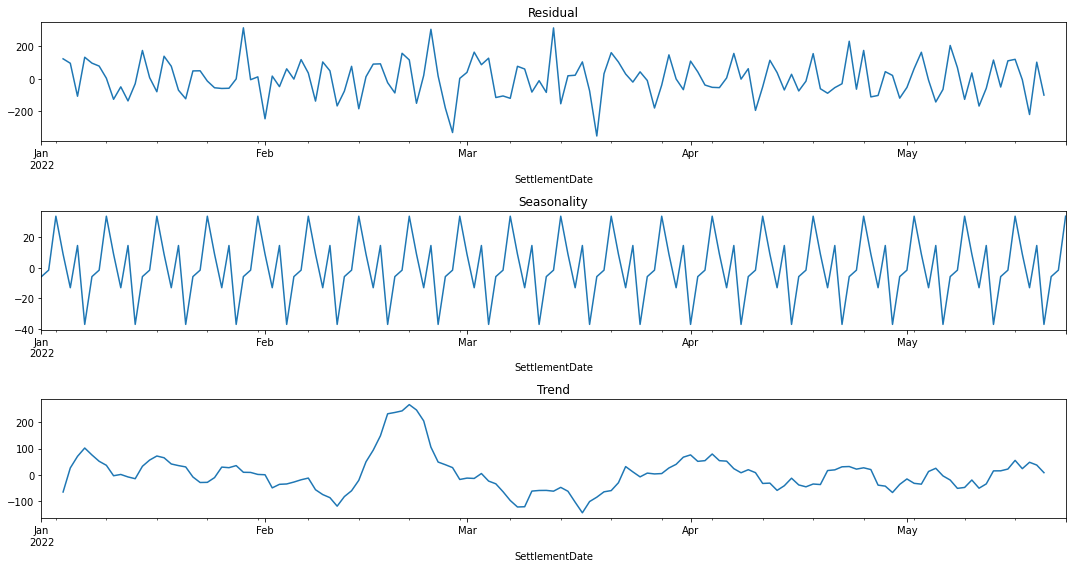

In [ ]:
# plot our target to confirm our previous hypotheses
target_2022 = df[df["year"] == 2022].dropna().groupby("SettlementDate")["ImbalanceQuantity(MAW)"].mean()
seasonal_plot(target_2022)

We can see a few things from this plot:
1. Our previous hypothesis about seasonal patterns do seem to show. This is present in the seasonal component, which includes roughly 4.5 peaks/troughs per month, which is representative of weekly repeating cycles.
2. There seems to be a trend towards February & March, which likely involves the current Ukraine and Russia situation. 
3. The residual is not entirely white noise, although it is zero-centred. The problem is that the variance is not constant, which is indicative of a non-stationary time series.

A few quick notes:
1. Should we attempt to obtain a stationary sequence, and perform model fitting on that data? 
- This is not desirable, since we can't expect to be able to perform an identical de-trending procedure in different years, which we will illustrate below with a seasonal decomposition on a year's data pre-Covid.
2. This prompts us to explore high-complexity methods such as neural networks, which have capabilities to "remember" past seasonal and trend patterns, but also be able to generalize to new data, which are potentially extreme.

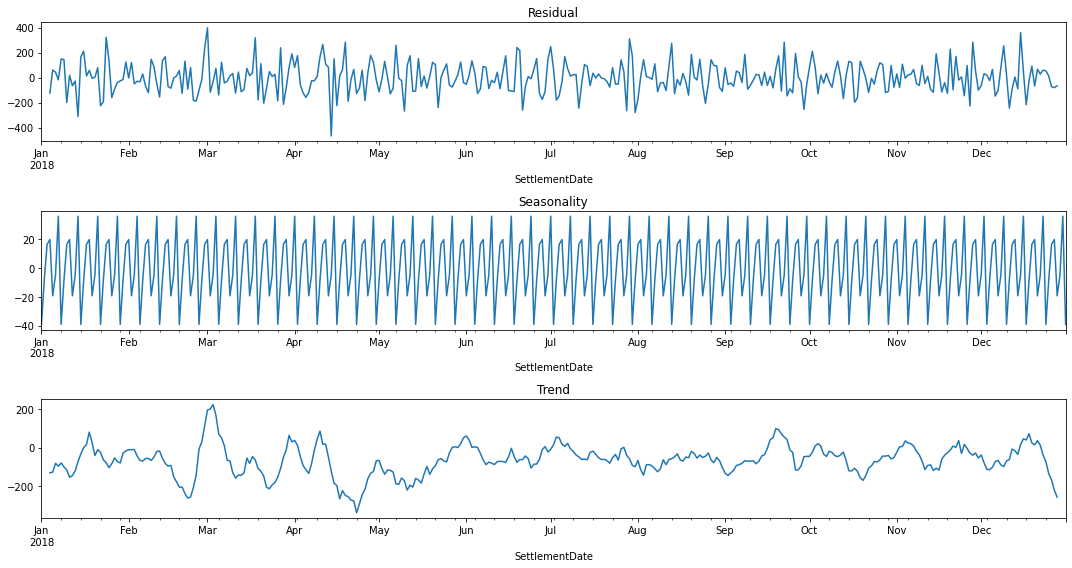

In [ ]:
# plot our target to confirm our previous hypotheses
target_2018 = df[df["year"] == 2018].groupby("SettlementDate")["ImbalanceQuantity(MAW)"].mean()
seasonal_plot(target_2018)

Now we will explore some of the day ahead features present in the data over the past year.

In [ ]:
def seasonal_var_plot(datafrm, year=2018, col_name=""):
  # Plot seasonal from gbd dataframe
  array = (datafrm[datafrm["SettlementYear"] == year]
          [datafrm['variable'] == col_name]
          .reset_index()
          .set_index("SettlementDate")["value"])
  seasonal_plot(array , suptitle="{} Seasonal Decomposition".format(col_name.upper()))

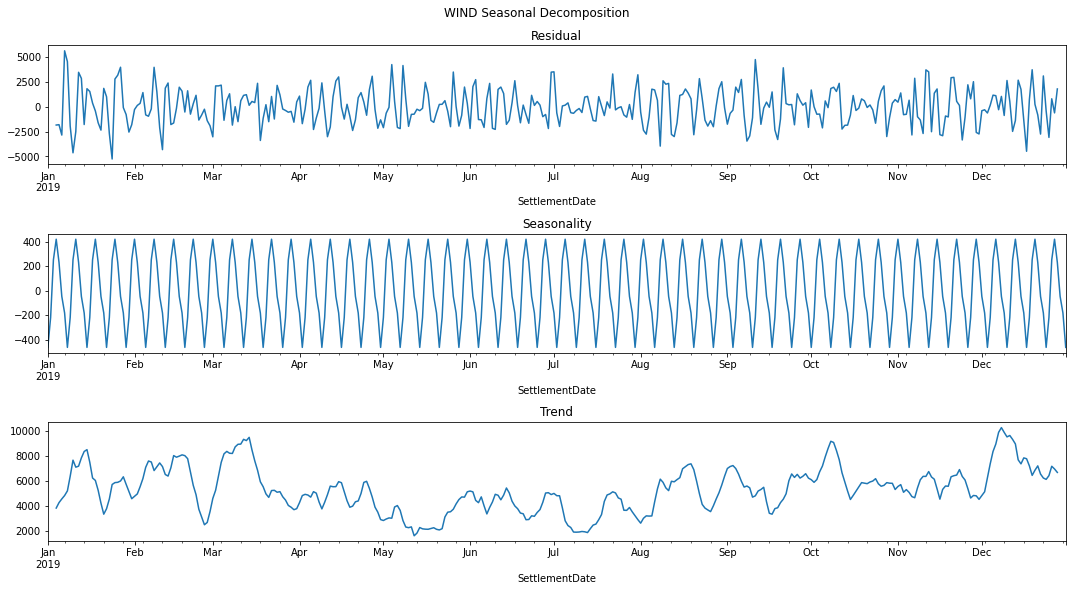

In [ ]:
# plot our target to confirm our previous hypotheses
seasonal_var_plot(energy_source_gbd_98, 2019, 'wind')

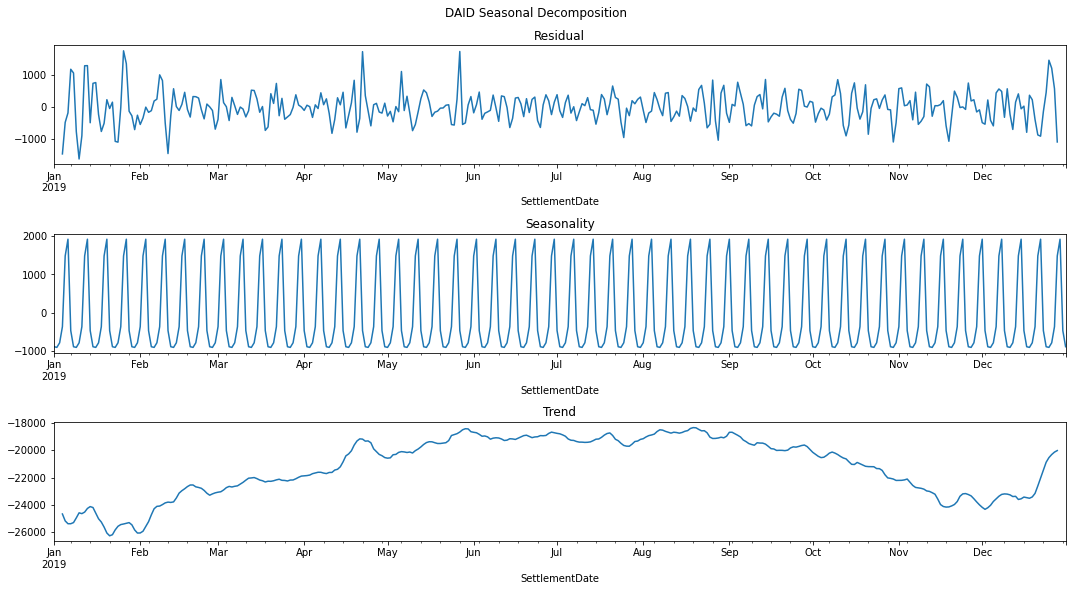

In [ ]:
seasonal_var_plot(day_ahead_gbd_33, 2019, 'DAID')

Day Ahead Indicated Demand (DAID) show the seasonal trend (highest in January-Mar and lowest in June-Aug). But also, the important think is that there is an increasing (in the economical sense) trend when it comes to demand-side features, which is reflective of current situations. 

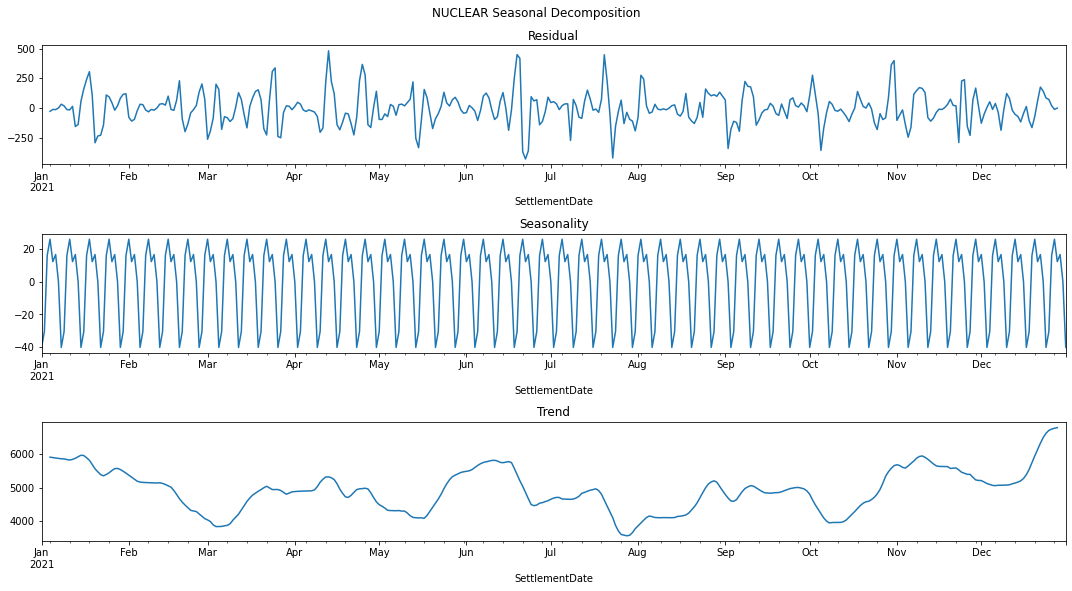

In [ ]:
# plot our target to confirm our previous hypotheses
seasonal_var_plot(energy_source_gbd_98, 2021, 'nuclear')

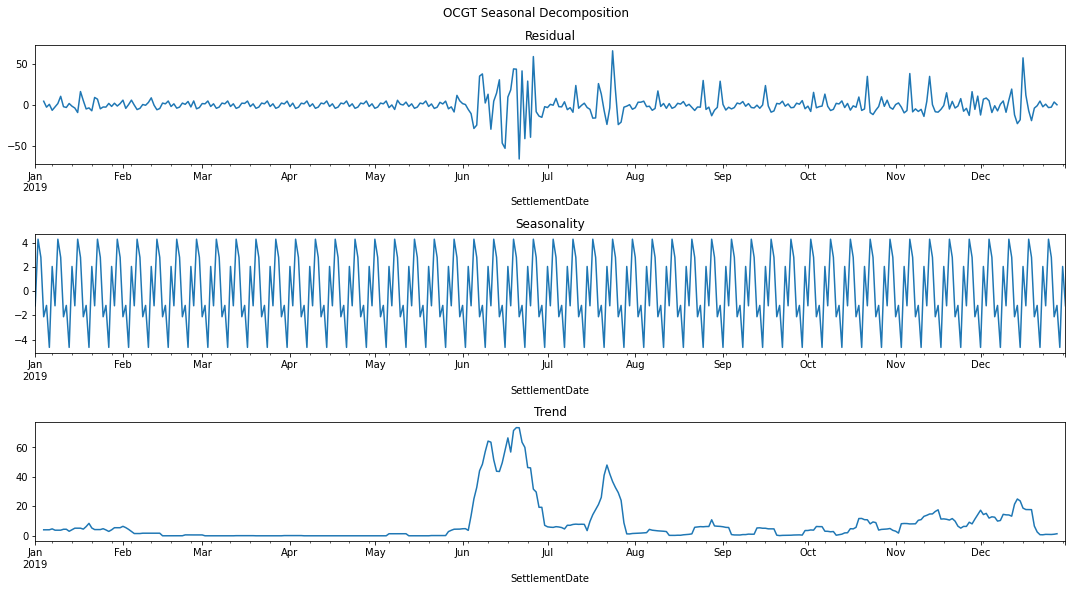

In [ ]:
seasonal_var_plot(energy_source_gbd_98, 2019, "ocgt")  

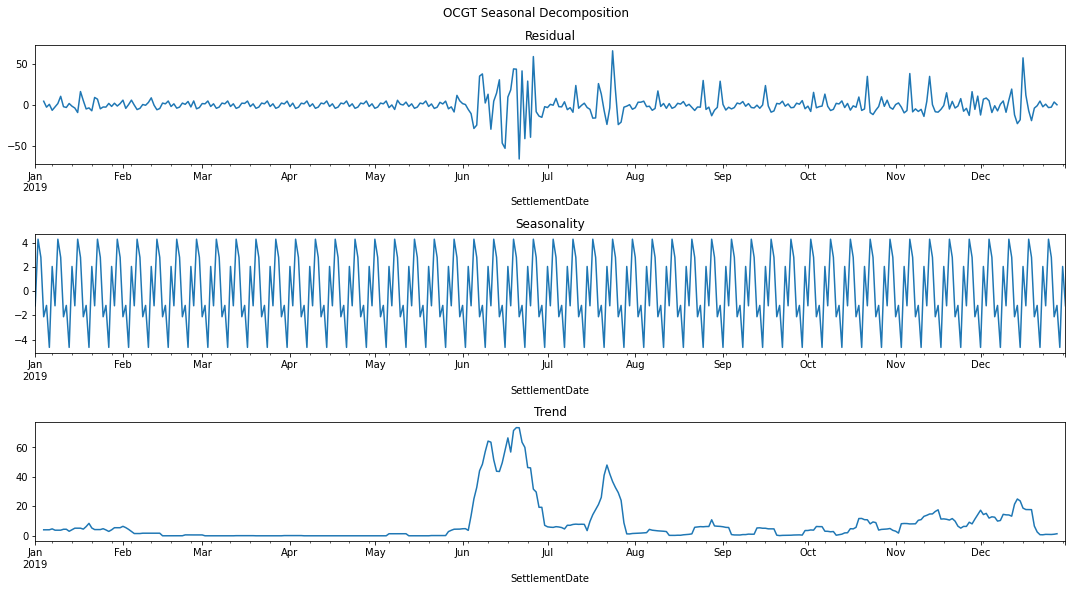

In [ ]:
# plot our target to confirm our previous hypotheses
seasonal_var_plot(energy_source_gbd_98, 2019, 'ocgt')

#### **Summary (Time Series)**:

Signal was broken down into 3 components:
1. Trend.
2. Additive seasonal component.
3. Residual noise, assumed to follow a standard normal distribution.

With respect to each component as well as the autocorrelation present in the target, the analysis suggests that we should:
1. Trend:
    - Include lag and differenced features. Some of the trend still contains seasonal patterns, which means that the simple decomposition didn't capture that information. 
    - Include features computed from rolling windows, to alleviate noise. 
    - Use a high complexity model, but also include proper regularization.

2. Seasonal component:
    - Seasonal patterns were similar throughout all of the columns, which suggests that extensive feature engineering could help the model incorporate those features better. Examples:
        - Binarized features based on time frames.
        - Repeated information or within a certain range.

3. Residual noise:
    - Was still not fully random, which means that there is useful information left in the residuals. 
    - This also suggests complex models might be beneficial, but also favours noise-reduction methods. Examples:
        - Clustering methods could help with noise, and have had moderate performance in the past.
        - Boosting methods could be useful to explain the noise, and ensembles methods are valid choices.

## ImbalanceQuantity Exploration

We will be exploring how NIV interacts with some of the features present in the data. 
- Firstly, we will assume the null hypothesis that some correlation are present between NIV and a subset of the energy generation features, although the degree and direction of correlation may vary. 
- Furthermore, we will assume that features that involve high energy generation facilities will have higher correlation with NIV. We will showcase this by first plotting out some of the most correlated features of NIV.

We will remove some of the market balancing feature as well as demand features. 

In [ ]:
# define the columns that involve market price/vol or balancing information
balance_cols = [
    "marketIndexPrice", 
    "marketIndexVolume", 
    "ImbalancePriceAmount", 
    "systemSellPrice", 
    "totalSystemAcceptedOfferVolume",
    "totalSystemAdjustmentSellVolume",
    "totalSystemAdjustmentBuyVolume",
    "totalSystemAcceptedBidVolume", 
    "indicativeNetImbalanceVolume",
    "DAI", 
    "DAM"
]

# define date columns
date_cols = [
    "local_datetime", 
    "SettlementDate", 
    "SettlementWeek",
    "SettlementPeriod",
    "year", 
    "month", 
    "day"
]

# define columns containing demand information
demand_cols = [c for c in df.columns if "B0" in c] + ["DAID", "DANF", "DATF"] 
demand_cols += ["ITSDO", "TSDF"] 

not_gen_cols = date_cols + balance_cols + demand_cols + ["temperature"]

# define energy generation features
gen_cols = [c for c in df.columns if c not in not_gen_cols and c != "ImbalanceQuantity(MAW)"]

We will also only select distinct generation types for individual exploration, since forecasts and actual values are likely higly correlated between each other already. As for the correlation matrix, I will be exploring the most correlated feature in absolute values relative to ImbalanceQuantity(MAW).

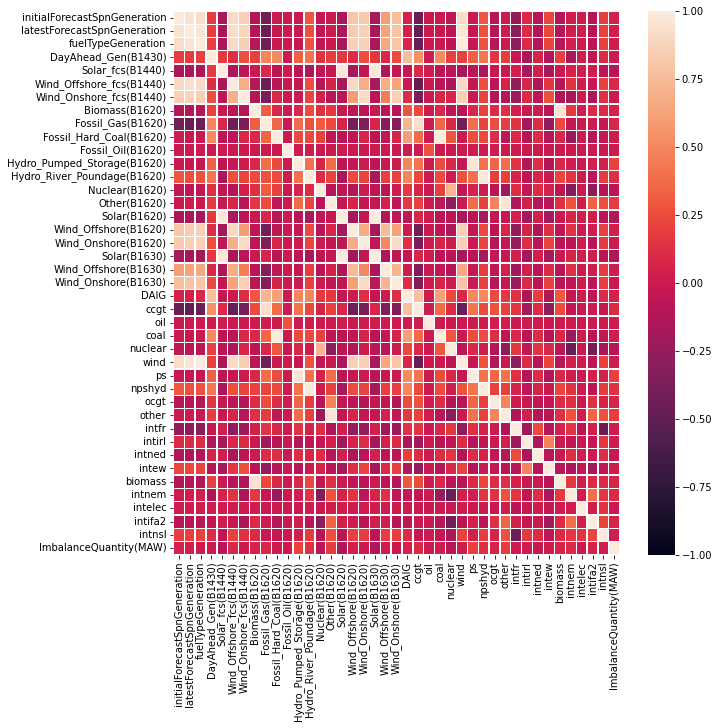

In [ ]:
# df that we will be working on, does not contain these balance information and date cols
imbqty_gen_df = df[gen_cols + ["ImbalanceQuantity(MAW)"]]

# plot correlation matrix
imbqty_gen_corr = imbqty_gen_df.corr()
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(imbqty_gen_corr, vmin=-1, vmax=1, linewidth=0.3)

We can see that while there is moderate correlation from feature to feature, correlation to ImbalanceQuantity(MAW) is not as significant. I will illustrate this in a more condensed plot of top 5 highest-correlated power generation-related features with ImbalanceQuantity(MAW).

Note that minimum value of this heatmap is 0 instead of 1, since I used the absolute correlation.

Top 10 Correlation values: 
intnem                         0.095935
ccgt                           0.096489
Solar(B1630)                   0.126930
Solar(B1620)                   0.127012
Hydro_River_Poundage(B1620)    0.130581
npshyd                         0.135028
Other(B1620)                   0.182079
other                          0.193283
ps                             0.208960
Hydro_Pumped_Storage(B1620)    0.211759
Name: ImbalanceQuantity(MAW), dtype: float64


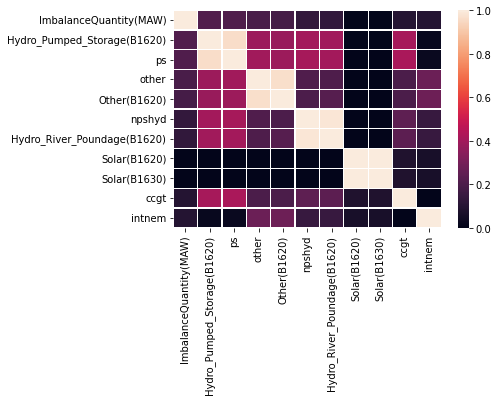

In [ ]:
# print out the top 10 correlated features in descending order of corr
imbqty_gen_corr_abs = imbqty_gen_corr["ImbalanceQuantity(MAW)"].abs().sort_values()[-11:]
print("Top 10 Correlation values: ")
print(imbqty_gen_corr_abs[:-1])

# plot the top 10 highest absolute correlations
imb_idx = imbqty_gen_corr_abs.index[::-1]
imbqty_gen_corr_abs = imbqty_gen_corr.loc[imb_idx, imb_idx]
sns.heatmap(imbqty_gen_corr_abs, vmin=0, vmax=1, linewidth=0.2)
plt.xticks(rotation=90)
plt.show()

Since we have a lot of features for power generation, we can also begin to add them up to see their total correlation. 

In [ ]:
total_gen_df = imbqty_gen_df.copy()  # only take the generation columns
# compute total power generation from wind sources
wind_cols = [c for c in df.columns if "wind" in c.lower() and c != "wind"]
total_gen_df["wind_fcs_total_B1440"] = df["Wind_Offshore_fcs(B1440)"] + df["Wind_Onshore_fcs(B1440)"]
total_gen_df["wind_actual_total_B1620"] = df["Wind_Offshore(B1620)"] + df["Wind_Onshore(B1620)"]
total_gen_df["wind_est_total_B1630"] = df["Wind_Offshore(B1630)"] + df["Wind_Onshore(B1630)"]

# compute total power generation from other sources
total_gen_df["int_gen_total"] = 0
int_cols = [c for c in df.columns if "int" in c]
for col in int_cols:
    total_gen_df["int_gen_total"] += df[col]
    
# compute fossil fuels generation totals
total_gen_df["fossil_fuel_total"] = df["Fossil_Gas(B1620)"] + df["Fossil_Hard_Coal(B1620)"] + df["Fossil_Oil(B1620)"]
fossil_cols = ["Fossil_Gas(B1620)", "Fossil_Hard_Coal(B1620)", "Fossil_Oil(B1620)"]

# compute hydro generation totals
total_gen_df["hydro_total"] = df["Hydro_Pumped_Storage(B1620)"] + df["Hydro_River_Poundage(B1620)"]
hydro_cols = ["Hydro_Pumped_Storage(B1620)", "Hydro_River_Poundage(B1620)"]

# drop individual columns that were used to sum
cols_to_drop = int_cols + wind_cols + fossil_cols + hydro_cols
total_gen_df.drop(cols_to_drop, axis=1, inplace=True)

# reorder columns
_ = total_gen_df.columns.to_list()
_.remove("ImbalanceQuantity(MAW)")
total_gen_df = total_gen_df[["ImbalanceQuantity(MAW)"] + sorted(_)]

total_gen_df.corr().loc["ImbalanceQuantity(MAW)"].sort_values()

Solar(B1620)                   -0.127012
Solar(B1630)                   -0.126930
nuclear                        -0.094306
Solar_fcs(B1440)               -0.091683
Nuclear(B1620)                 -0.071158
DayAhead_Gen(B1430)             0.001658
oil                             0.002434
fuelTypeGeneration              0.002437
wind                            0.002437
wind_est_total_B1630            0.007399
wind_actual_total_B1620         0.015397
coal                            0.015692
latestForecastSpnGeneration     0.041287
wind_fcs_total_B1440            0.046365
DAIG                            0.050978
int_gen_total                   0.055544
initialForecastSpnGeneration    0.057190
Biomass(B1620)                  0.059444
biomass                         0.064214
ocgt                            0.069023
fossil_fuel_total               0.080368
ccgt                            0.096489
npshyd                          0.135028
Other(B1620)                    0.182079
other           

We will also show how the target correlates with demand features. Since they are smaller in quantity, we can plot all of them in the same heatmap.

Sorted Correlation Values: 
DAID                     -0.070380
DayAhead_Load(B0620)      0.060467
Total_Load(B0610)         0.082957
DATF                      0.086527
TSDF                      0.086527
DANF                      0.092534
ITSDO                     0.108040
ImbalanceQuantity(MAW)    1.000000
Name: ImbalanceQuantity(MAW), dtype: float64


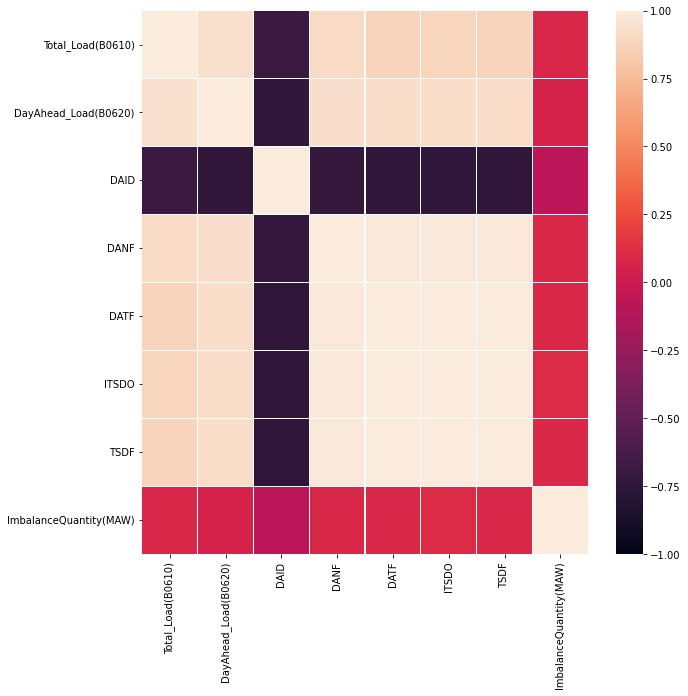

In [ ]:
# df that we will be working on, does not contain these balance information and date cols
imbqty_dem_df = df[demand_cols + ["ImbalanceQuantity(MAW)"]]
print("Sorted Correlation Values: ")
print(imbqty_dem_df.corr()["ImbalanceQuantity(MAW)"].sort_values())

# plot correlation matrix
imbqty_dem_corr = imbqty_dem_df.corr()
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(imbqty_dem_corr, vmin=-1, vmax=1, linewidth=0.3)

We can see that ImbalanceQuantity is most correlated with peak demand and forecasted system demand, which is expected, but also that power generation seems to have higher absolute correlation with ImbalanceQuantity(MAW).

We can explore forecasted and day ahead data closer to see how they correlate with NIV.

#### Correlation between NIV and forecasted data

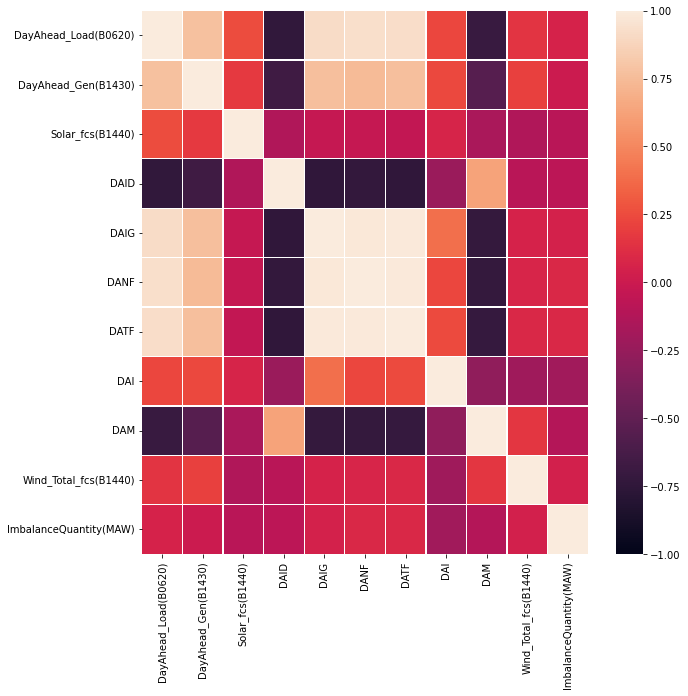

In [ ]:
# get the forecasted and day ahead column names
load_cols = [c for c in df.columns if "B0620" in c]
da_gen_cols = [c for c in df.columns if "B1430" in c]
da_ws_fcs = [c for c in df.columns if "B1440" in c]
da_cols = [c for c in df.columns if "DA" in c]
fcs_cols = load_cols + da_gen_cols + da_ws_fcs + da_cols

# make forecast df
df_fcs = df[fcs_cols]

# make total wind column
df_fcs["Wind_Total_fcs(B1440)"] = df_fcs["Wind_Offshore_fcs(B1440)"] + df_fcs["Wind_Onshore_fcs(B1440)"]
df_fcs.drop(["Wind_Offshore_fcs(B1440)", "Wind_Onshore_fcs(B1440)"], axis=1, inplace=True)

# include NIV
df_fcs["ImbalanceQuantity(MAW)"] = df["ImbalanceQuantity(MAW)"]

# plot correlation matrix
df_fcs_corr = df_fcs.corr()
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df_fcs_corr, vmin=-1, vmax=1, linewidth=0.3)

In [ ]:
print("Sorted Correlation Values Relative To NIV: ")
print(df_fcs.corr()["ImbalanceQuantity(MAW)"].sort_values())

def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')
def describe(df):
    des = df 
    cm = sns.light_palette("red", as_cmap=True)
    return des.style.text_gradient(cmap=cm)
describe(df_fcs_corr)
#df_fcs_corr

Sorted Correlation Values Relative To NIV: 
DAI                      -0.195572
DAM                      -0.112102
Solar_fcs(B1440)         -0.091683
DAID                     -0.070380
DayAhead_Gen(B1430)       0.001658
Wind_Total_fcs(B1440)     0.046365
DAIG                      0.050978
DayAhead_Load(B0620)      0.060467
DATF                      0.086527
DANF                      0.092534
ImbalanceQuantity(MAW)    1.000000
Name: ImbalanceQuantity(MAW), dtype: float64


While DAI has the highest absolute correlation with the target, this is likely because it is forecasted based on ImbalanceQuantity(MAW), so we shouldn't use this because it might lead to overly optimistic predictions. 

#### **Summary**

We didn't explore the balance information because there might be data leakage. To summarize the section, power generation features seem to be more correlated with our target variable, but does not have full predictive influence, which is to be expected, since the data is likely to be noisy.

A few takeaways:
- Demand side features concerning peak load are more correlated -> we can use features concerning basic statistics of current columns. 

- On the power generation side, these features seem to be more correlated overall with NIV, but some of them have higher frequency of unavailability. We can incorporate this into our features, for example:
    - Binarize availability of columns.
    - Forecast of weather information (using Met).

## Bivariate Analysis 

In this part, we analyst the relationship between each pair of 2 columns. We tried to find correlation and pattern so that can help for selecting feature and eliminating unnecessary columns. 

In [ ]:
class BivariateAnalysis:

    def __init__(self, data, date_col='', columns=''):
        """
        Bivariate Analysis data.

        This class contains method for transform data and
        function for visualize data to scatter plot and
        box plot

        Parameters:
        data: pd.DataFrame
        DataFrame contains data for analysis
        date_col: str
        Columns contains datetime value. using for datetime grouping
        columns: list
        List of columns in data. by default, all data will be used to analysis.
        """
        self.data = data.copy()
        if not columns:
            self.columns = data.columns
        else:
            self.columns = columns
        self.date_col = date_col
        self.cols_selected = []

    def check_data(self, col):
        """
        Helper function for check column name has been data.
        
        Parameter:
        col: str
        Columns will be checked
        
        Return: bool
        True if col is a column name in data, otherwise return False.
        """
        if col not in self.columns:
            return False
        return True

    def get(self, cols):
        """Get data by column's name.
        Parameter:
        cols: str
            Column name wants to retrive
        Return:
        Pandas.Series data if cols input is correct, otherwise
        an Error will trigger."""
        if isinstance(cols, list):
            for item in cols:
                if not self.check_data(item):
                    raise ValueError(f"Unknown column {item}")
        return self.data[col]
    
    def release_cols_selected(self):
        """Set columns selected is None."""
        self.cols_selected = []

    def prepare_cols_selected(self, *cols):
        """
        Normalize and filter all columns needed.
        Function will transform input to list and remove
        all columns not in dataframe.
        
        Parameter:
        *cols:
            Multiple input
        
        """
        self.release_cols_selected()
        for col in cols:
            if isinstance(col, str):
                self.cols_selected.append(col)
            elif isinstance(col, list):
                self.cols_selected.extend(col)
            else:
                raise TypeError(f"Type {type(col).__name__} not support")
        
        # Make sure not duplicated columns
        self.cols_selected = list(set(self.cols_selected))

    def ensure_xy_is_correct(self, vars):
        """
        Make sure all columns name was correctly and
        contains as list of columns.
        
        Parameters:
        vars: any
            Columns or list of columns will be checked
        Return:
        List of columns name correct.
        """
        if isinstance(vars, str):
            if self.check_data(vars):
               return [vars]
            else:
                # Unknown columns name, raise value
                raise ValueError(f"{vars} not in columns")
        elif isinstance(vars, list):
            vars = [var for var in vars if self.check_data(var)]

        if not vars:
            raise TypeError(f"{type(vars)} type is not supported")
        return vars
 
    def group_data(self, by, cols, mode='mean'):
        if mode not in ['mean', 'sum', 'min', 'max']:
            raise ValueError(f"Unknown mode {mode}")
        if by not in cols:
            cols.insert(0, by)

        data = self.data[cols]
        return data.groupby(by).agg(mode).reset_index()

    def unpivot(self, date_col='', features='', **kwargs):
        vars = kwargs.pop("var_name", "variable")
        val = kwargs.pop("value_name", "value")
        if not date_col:
            date_col = self.date_col

        if not features:
            features = self.columns

        if date_col in features:
            features.remove(date_col)

        df = self.data[[date_col] + features]
        df = df.groupby([date_col]).mean().reset_index()
        return pd.melt(df, [date_col], var_name=vars, value_name=val)

    def get_boxplot(self, cate_cols):
        cate_cols = self.ensure_xy_is_correct(cate_cols)
        new_df = self.unpivot(date_col='SettlementDate', features=cate_cols)
        plt.figure(figsize=(10,8))
        plt.title("Distribution of data")
        sns.boxplot(x='value', y='variable', data=new_df, palette='rainbow')
        plt.show()

    def single_scatter(self, data, x_vars, y_vars):
        y = y_vars[0]
        x = x_vars
        yy = data[y]
        n = len(x)
        fig, ax = plt.subplots(n, 1, figsize=(12,n*3))
        for i in range(len(x)):
            xx = data[x[i]]
            sns.scatterplot(x=xx, y=yy, ax=ax[i]).set_title(f"Distribution between {y} and {x[i]}")
            sns.kdeplot(x=xx, y=yy, ax=ax[i], fill=True, levels=5, alpha=0.5)
        plt.tight_layout()
        plt.show()

    def pair_scatter(self, data, x_vars, y_vars):
        # w = 3 * len(y_vars)
        # h = 3 * len(x_vars)
        g = sns.PairGrid(data, x_vars=x_vars, y_vars=y_vars)
        # sns.kdeplot(x_vars=x_vars, y_vars=y_vars, ax=ax[i], fill=True, levels=5, alpha=0.5)
        # g.figure.set(figheight=h, figwidth=w)
        g.map(sns.scatterplot)
        g.map(sns.kdeplot)
        g.add_legend()
        g.tight_layout()

    def get_scatterplot(self, target, features, visualize_to='single'):
        """
        Visualize data to scatter chart.
        Using for depth-understanding correlation between features of dataset.

        Parameters:
        target: optional[list, str]
            Features target want to know.
            Warning: only one feature support with single mode (visualize_to='single')
        features: list/str
            Features want to analysis.
        visualize_to: {'single', 'pair'}, default: single
            Method for analysis.
        """
        if visualize_to == 'pair':
            f = self.pair_scatter
        elif visualize_to == 'self':
            f = self.self_scatter
        elif visualize_to == 'single':
            f = self.single_scatter
        target = self.ensure_xy_is_correct(target)
        features = self.ensure_xy_is_correct(features)
        self.prepare_cols_selected(target, features)
        data = self.group_data(by='SettlementDate', cols=self.cols_selected, mode='sum')
        f(data, features, target)

    def self_scatter(self, data, x_vars, y_vars):
        """
        Visualization scatter chart with PairGrid.

        An generic version of scatter with Seaborn PairGrid.

        Parameters:
        data: pd.DataFrame
            DataFrame contains all features
        x_vars: list-like
            List of features want to visualize. Each of feature's representation on x-axes.
        y_vars: str
            Name of feature want to visualize. It's representation as Y-axes
        """
        # w = 3 * len(y_vars)
        # h = 3 * len(x_vars)
        g = sns.PairGrid(data[x_vars])
        # g.figure.set(figheight=h, figwidth=w)
        g.map_upper(sns.scatterplot)
        g.map_diag(sns.histplot)
        g.add_legend()
        g.tight_layout()

In [ ]:
x = BivariateAnalysis(df, date_col='SettlementDate')

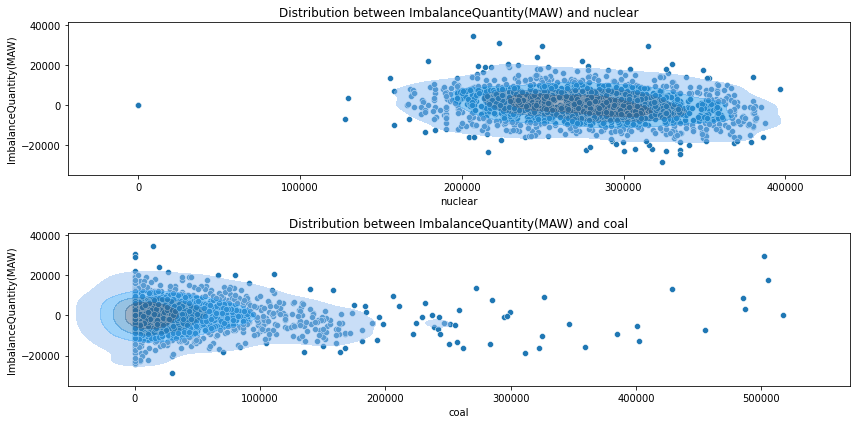

In [ ]:
x.get_scatterplot(target='ImbalanceQuantity(MAW)', features=col[:2], visualize_to='single')

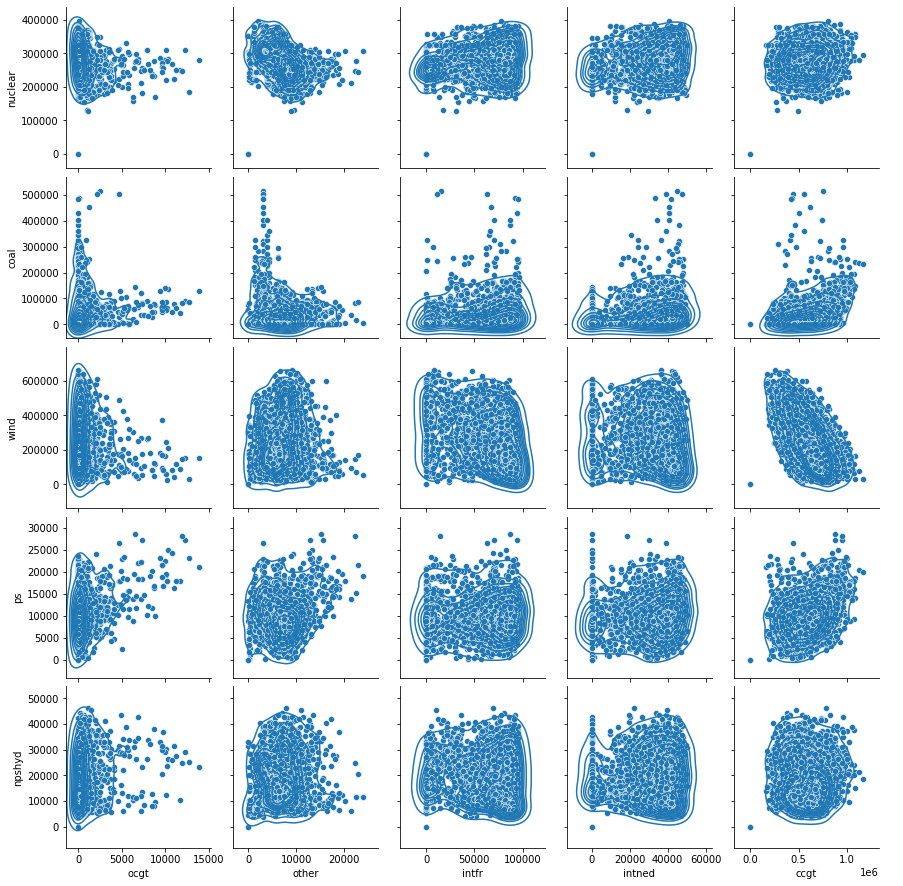

In [ ]:
x.get_scatterplot(target=col[:5], features=col[5:10], visualize_to='pair')

In [ ]:
# x.get_boxplot(['ImbalanceQuantity(MAW)'])

After further inspection, the following features are removed from later stages:
1. fuelTypeGeneration
2. initialForecastSpnGeneration and latestForecastSpnGeneration
3. systemSellPrice and ImbalancePriceAmount
4. DayAhead_Gen(B1430)
5. Date columns will be transformed for later usage.


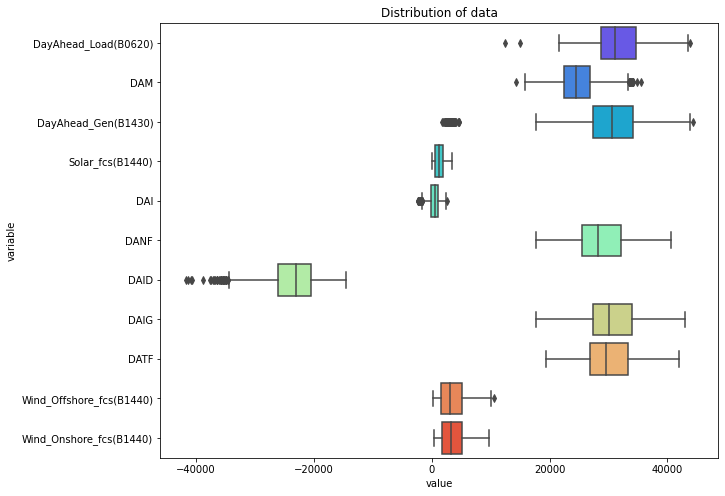

In [ ]:
# Visualize BoxPlot of Forecasted Data
def extract_and_group(columns, df=df):
  """
  Helper function for extract data by group and perform some preprocessing.
  Param:
    columns: list of strings -> list[str]
    df: dataframe for processing -> pd.DataFrame
  Returns:
    pd.DataFrame
  """
  sub_df = df[columns].dropna()
  sub_df['SettlementDate'] = pd.to_datetime(sub_df.SettlementDate)
  sub_df = sub_df.groupby('SettlementDate').mean().reset_index()
  return pd.melt(sub_df, ['SettlementDate']).sort_values('SettlementDate')


def visualize_boxplot(df, col_list):
  new_df = extract_and_group(['SettlementDate'] + col_list, df)
  plt.figure(figsize=(10,8))
  plt.title("Distribution of data")
  sns.boxplot(x='value', y='variable', data=new_df, palette='rainbow')
  plt.show()

# visualize_boxplot(df, load_cols)
# visualize_boxplot(df, da_gen_cols)
# visualize_boxplot(df, da_ws_fcs)
# visualize_boxplot(df, da_cols)
visualize_boxplot(df, fcs_cols)